<a href="https://colab.research.google.com/github/arpanbiswas52/TEAMS/blob/main/BO_tutorial_TEAMS2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classical and structured Bayesian optimization**
March, 2024

-- Notebook prepared by **Arpan Biswas** for APS March Meeting 2024 Workshop **Data Science for Physicists II**

-- Gpax package is developed by **Maxim Ziatdinov**



# Install Gpax package

In [1]:
!pip install -q git+https://github.com/ziatdinovmax/gpax.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import gpax
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand

from tqdm import tqdm

gpax.utils.enable_x64()  # enable double precision

from typing import Union, Dict, Callable

import math

import jax.numpy as jnp
from jax import jit
from gpax.kernels import RBFKernel, MaternKernel

import jax
import numpyro

import time


# Test Problem 1

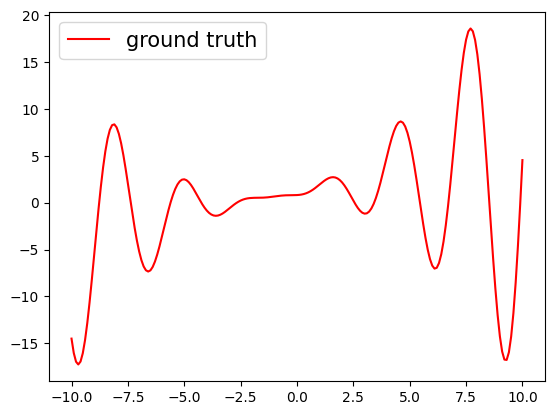

In [3]:
def objective(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * np.sin(2 * x + 2) / 5 + 1 + x / 3
    return y



lb = -10
ub = 10

bounds = np.array((lb, ub), dtype=float)
fidelities = np.array((1, 2))

xs = np.linspace(lb, ub, 201)
xs_norm = (xs-lb)/(ub-lb)

ys = objective(xs)

plt.plot(xs, ys, label="ground truth", c="r")

plt.legend(fontsize=15);

# Initial Samples

- Let choose 25 samples randomly

In [4]:
n = 25

np.random.seed(10)
train_x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 1)
train_x

array([[ 5.42641287],
       [-9.58496101],
       [ 2.6729647 ],
       [ 4.97607765],
       [-0.02985975],
       [-5.50406709],
       [-6.0387427 ],
       [ 5.21061424],
       [-6.61778327],
       [-8.23320372],
       [ 3.70719637],
       [ 9.06786692],
       [-9.92103467],
       [ 0.24384527],
       [ 6.25241923],
       [ 2.25052134],
       [ 4.43510635],
       [-4.16247864],
       [ 8.35548245],
       [ 4.29151567],
       [ 0.85088736],
       [-7.15659905],
       [-2.5331848 ],
       [ 3.4826723 ],
       [-1.16333651]])

In [5]:
train_y = objective(train_x)
train_y

array([[  0.47498059],
       [-16.84808023],
       [ -0.4663544 ],
       [  6.77515555],
       [  0.81451556],
       [  0.8072842 ],
       [ -4.09685422],
       [  3.85262089],
       [ -7.33692538],
       [  8.15741373],
       [  2.18971041],
       [-15.43418551],
       [-15.76469002],
       [  0.89305901],
       [ -6.73232454],
       [  1.29343548],
       [  8.34008148],
       [ -0.30396262],
       [  6.20343919],
       [  7.56071412],
       [  1.64768064],
       [ -3.2843316 ],
       [  0.19093642],
       [  0.37876178],
       [  0.61393338]])

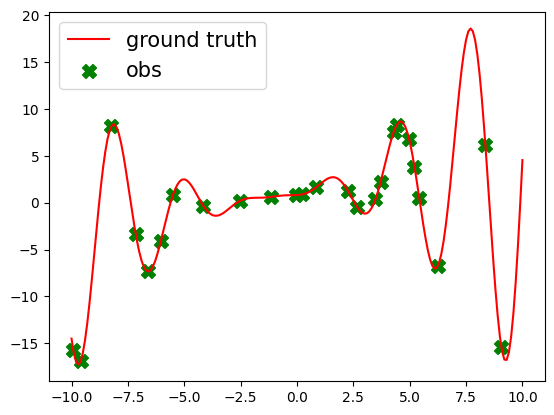

In [6]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.scatter(train_x, train_y, c="g", marker="X", label="obs", s=100)

plt.legend(fontsize=15);

# Define GP hyperparater prior distribution

In [7]:
def kernel_prior() -> Dict[str, jnp.ndarray]:
    length = numpyro.sample("k_length", numpyro.distributions.LogNormal(0, 1))
    scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
    return {"k_length": length, "k_scale": scale}

# Run GP

In [8]:
X_test =xs


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:07<00:00, 137.91it/s, 3 steps of size 5.27e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.68      0.16      0.67      0.42      0.92    278.41      1.00
   k_scale     39.87     14.36     35.96     20.04     58.84    242.31      1.00
     noise      0.77      0.95      0.55      0.02      1.64    364.98      1.00



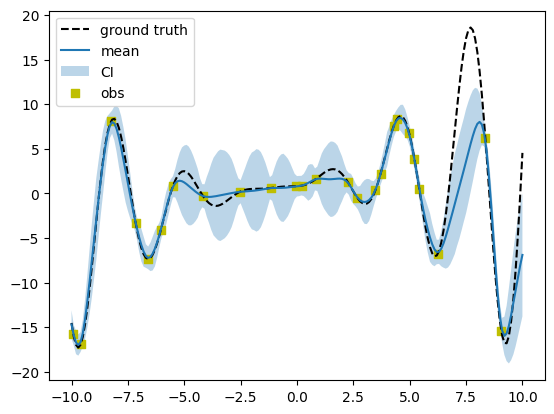

In [9]:
# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
# Initialize model
gp_model = gpax.ExactGP(1, kernel='Matern', kernel_prior = kernel_prior, noise_prior = lambda: numpyro.sample("noise", numpyro.distributions.LogNormal(0,1)))
# Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
gp_model.fit(rng_key, train_x, train_y, num_warmup=500, num_samples=500, num_chains=1)

y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test)
plt.plot(xs, ys, "k--", label="ground truth")
pred_lower = y_pred - y_sampled.std(axis=(0,1))
pred_upper = y_pred + y_sampled.std(axis=(0,1))
plt.plot(xs, y_pred, label="mean")
plt.fill_between(
    xs.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="CI",
)
plt.scatter(train_x, train_y, c="y", marker="s", label="obs")

plt.legend(loc="best")
plt.show()

# Initial Samples

- Let choose 10 samples randomly

- Then we explore next 15 samples autonomously

In [10]:
n = 10

np.random.seed(100)
train_x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 1)
train_x

array([[ 0.86809884],
       [-4.4326123 ],
       [-1.50964819],
       [ 6.89552265],
       [-9.90562288],
       [-7.56861758],
       [ 3.41498169],
       [ 6.5170551 ],
       [-7.26586821],
       [ 1.50186659]])

In [11]:
train_y = objective(train_x)
train_y

array([[  1.68034988],
       [  0.81793395],
       [  0.54103032],
       [  4.33317096],
       [-15.96776232],
       [  3.14007918],
       [ -0.04616851],
       [ -3.87962853],
       [ -1.6938571 ],
       [  2.69973408]])

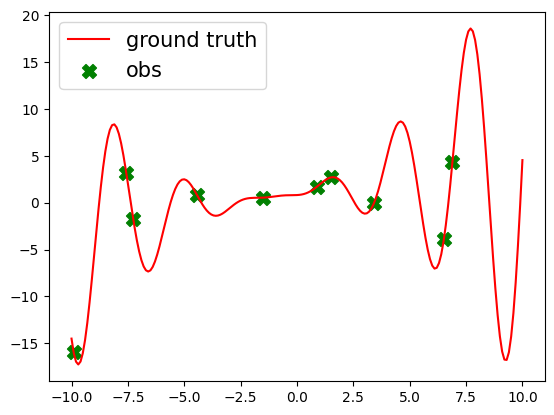

In [12]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.scatter(train_x, train_y, c="g", marker="X", label="obs", s=100)

plt.legend(fontsize=15);

# Define GP hyperparater prior distribution

In [13]:
def kernel_prior() -> Dict[str, jnp.ndarray]:
    length = numpyro.sample("k_length", numpyro.distributions.LogNormal(0, 1))
    scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
    return {"k_length": length, "k_scale": scale}

# Run BO

Step:1


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 144.00it/s, 3 steps of size 3.62e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.16      1.53      0.76      0.06      2.61    298.88      1.00
   k_scale      4.90      8.04      1.72      0.03     15.61     75.78      1.03
     noise     17.31      9.48     16.79      0.10     28.85    124.30      1.03



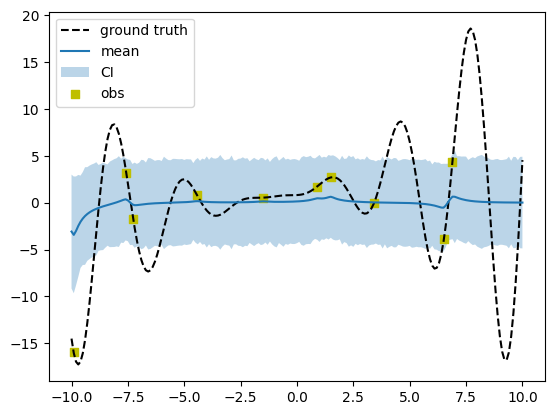

170


<ipython-input-14-83428f2a3aeb>:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx = int(idx)


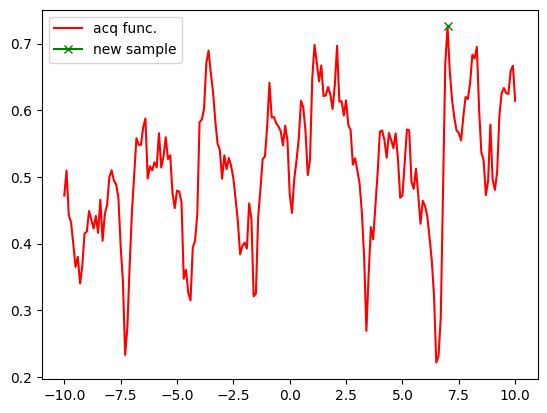

/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(


Step:2


sample: 100%|██████████| 1000/1000 [00:07<00:00, 127.36it/s, 3 steps of size 2.58e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.95      1.08      0.58      0.06      2.08    134.32      1.00
   k_scale      8.31     10.26      2.70      0.03     23.48     72.02      1.04
     noise     15.07     10.59     15.73      0.10     28.37     93.35      1.02



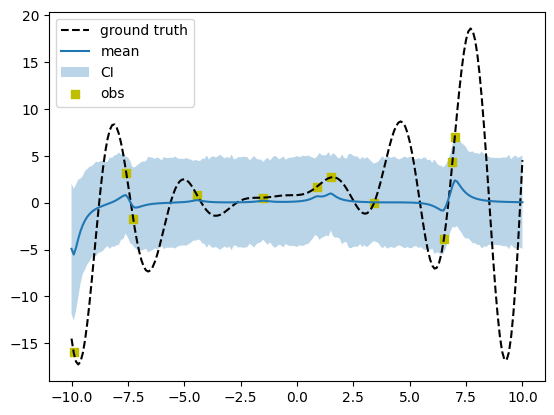

[170 171]


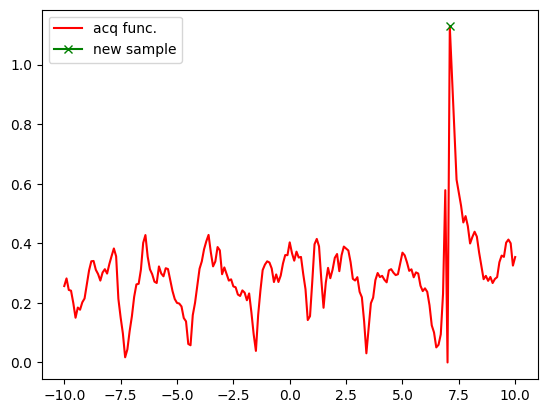

Step:3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:07<00:00, 126.99it/s, 7 steps of size 3.37e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.95      1.90      0.43      0.05      2.30     85.58      1.00
   k_scale     19.33     13.75     20.11      0.13     35.44     30.89      1.00
     noise      7.84     11.39      1.57      0.05     26.53     20.08      1.02



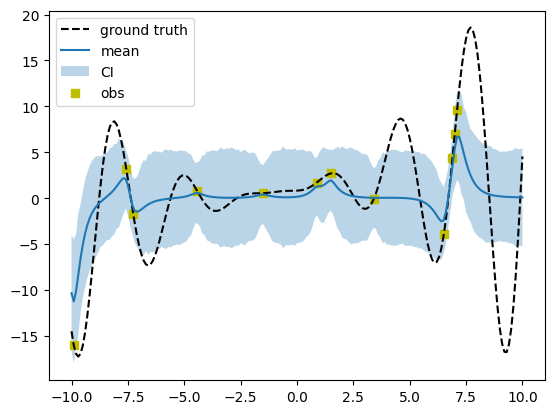

[170 171 172]


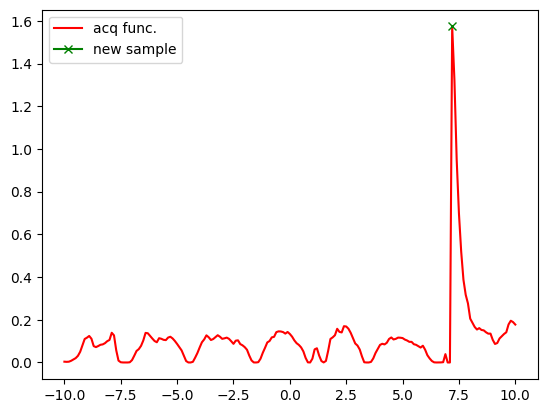

Step:4


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 155.41it/s, 7 steps of size 6.06e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.61      0.70      0.47      0.16      0.87     46.51      1.01
   k_scale     27.73     15.03     25.74      1.02     46.23     72.30      1.00
     noise      3.63      7.65      0.77      0.03     14.02     22.92      1.01



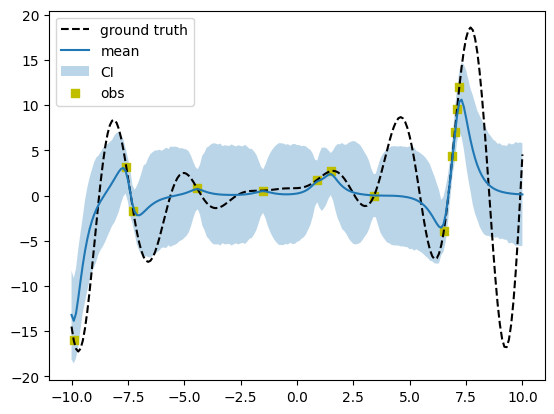

[170 171 172 173]


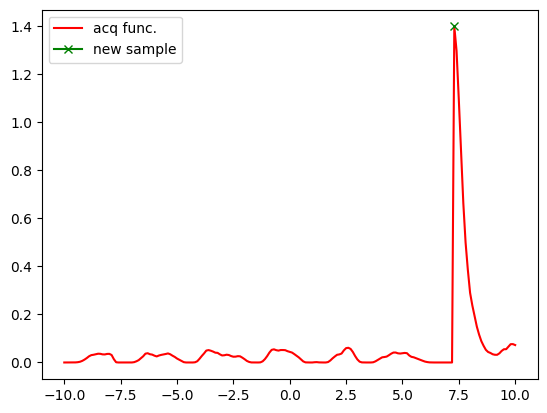

Step:5


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 163.22it/s, 7 steps of size 6.03e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.56      0.19      0.55      0.21      0.80    171.49      1.00
   k_scale     34.73     14.20     31.61     14.18     53.68    250.01      1.00
     noise      0.76      0.96      0.44      0.03      1.71    159.01      1.01



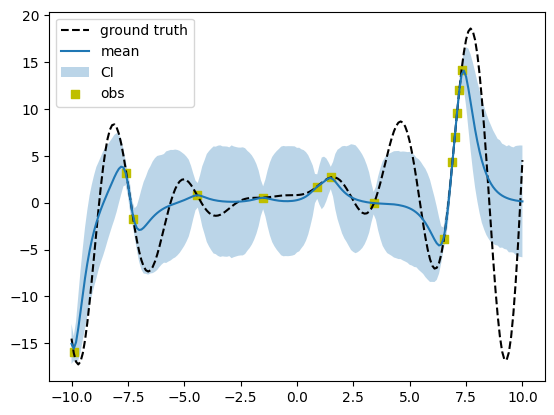

[170 171 172 173 175]


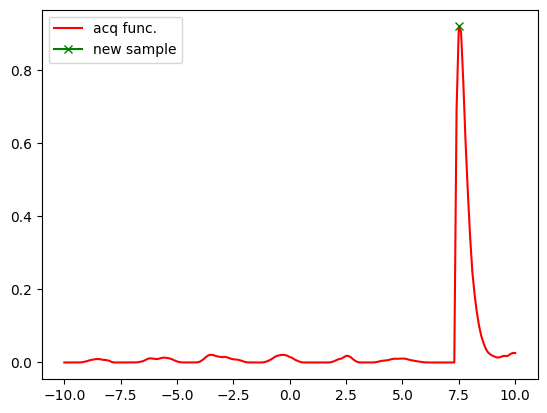

Step:6


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 162.72it/s, 3 steps of size 6.39e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.71      0.20      0.70      0.40      1.01    342.90      1.00
   k_scale     42.77     16.91     38.91     20.73     65.83    314.50      1.00
     noise      0.46      0.49      0.31      0.01      1.05    273.51      1.00



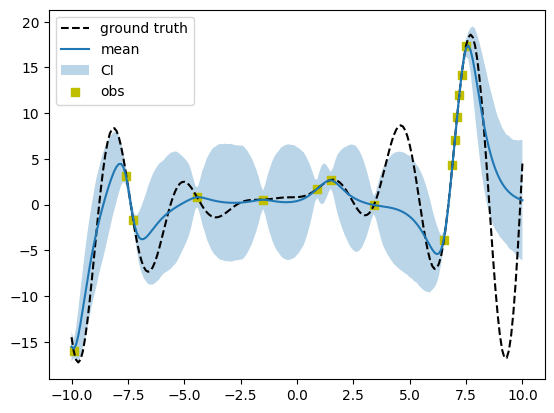

[170 171 172 173 175 178]


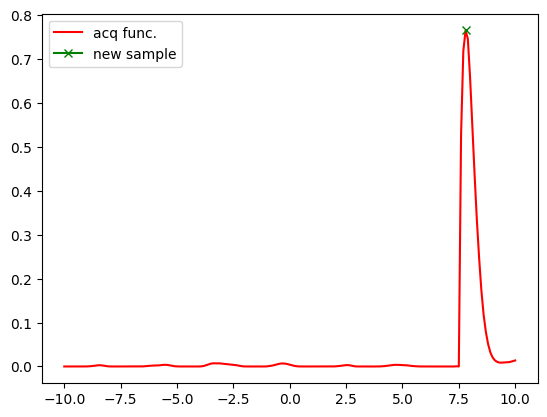

Step:7


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 165.40it/s, 3 steps of size 7.71e-01. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.81      0.18      0.80      0.49      1.09    326.18      1.00
   k_scale     46.26     16.28     43.47     21.07     68.00    302.22      1.00
     noise      0.39      0.42      0.24      0.03      0.89    376.76      1.00



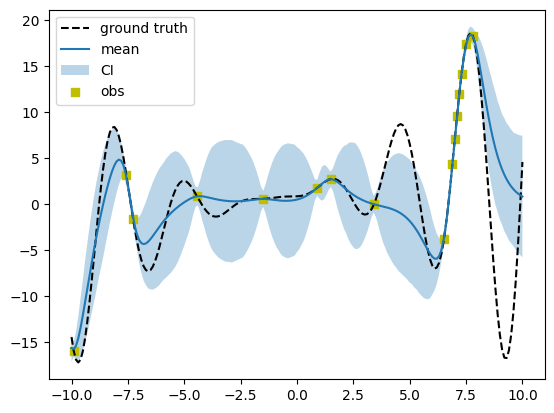

[170 171 172 173 175 178 177]


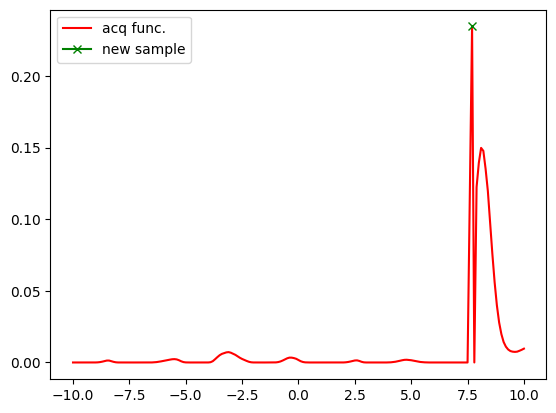

Step:8


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 152.31it/s, 5 steps of size 7.27e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.83      0.17      0.82      0.57      1.09    286.86      1.00
   k_scale     46.17     16.04     43.08     21.60     67.16    235.21      1.00
     noise      0.27      0.28      0.18      0.01      0.63    304.26      1.00



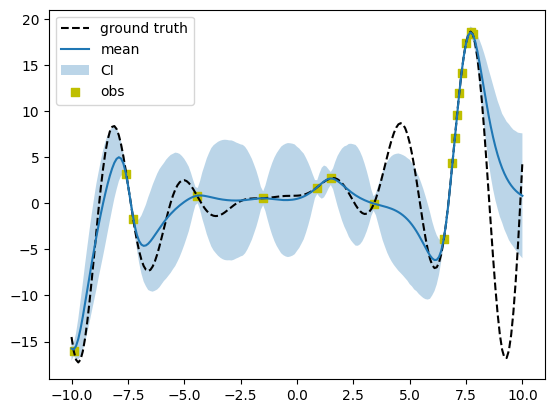

[170 171 172 173 175 178 177 181]


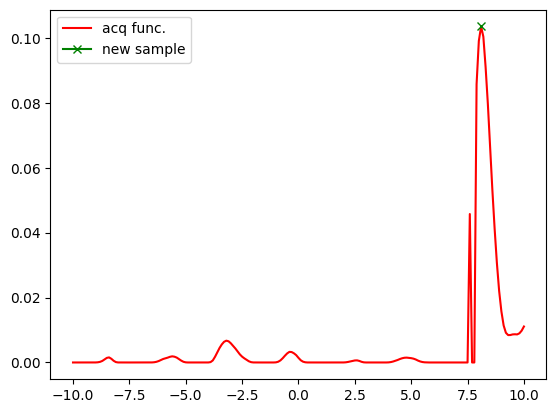

Step:9


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 149.58it/s, 3 steps of size 5.43e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.80      0.15      0.80      0.56      1.04    265.68      1.00
   k_scale     44.19     15.91     40.86     20.78     65.23    258.61      1.00
     noise      0.26      0.27      0.18      0.01      0.54    263.70      1.00



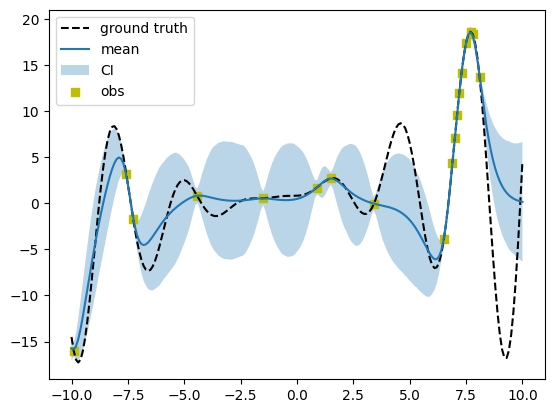

[170 171 172 173 175 178 177 181 176]


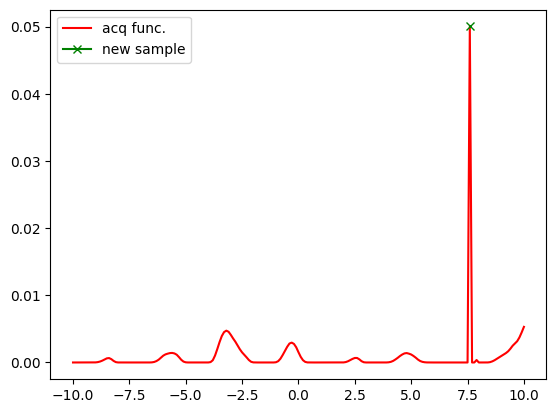

Step:10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 151.31it/s, 7 steps of size 6.70e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.81      0.15      0.80      0.52      1.01    309.85      1.00
   k_scale     44.78     15.31     41.92     22.66     68.60    302.78      1.00
     noise      0.17      0.17      0.12      0.01      0.34    318.39      1.00



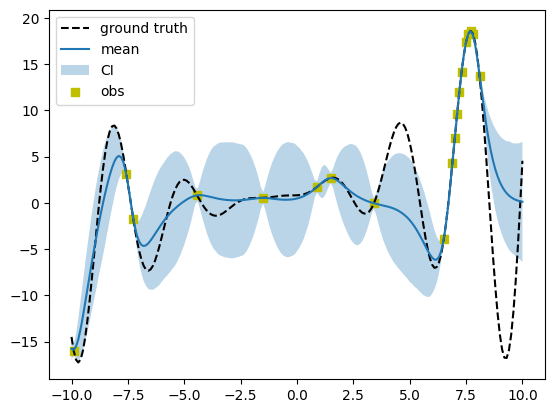

[170 171 172 173 175 178 177 181 176 200]


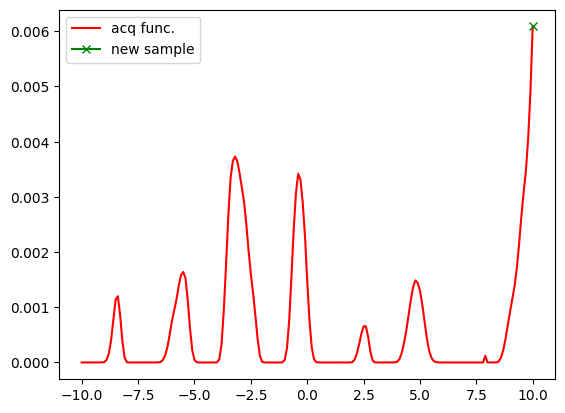

Step:11


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 153.34it/s, 3 steps of size 7.15e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.81      0.15      0.81      0.56      1.02    329.74      1.00
   k_scale     44.14     14.76     41.28     20.74     65.01    233.37      1.00
     noise      0.18      0.19      0.12      0.01      0.42    305.56      1.00



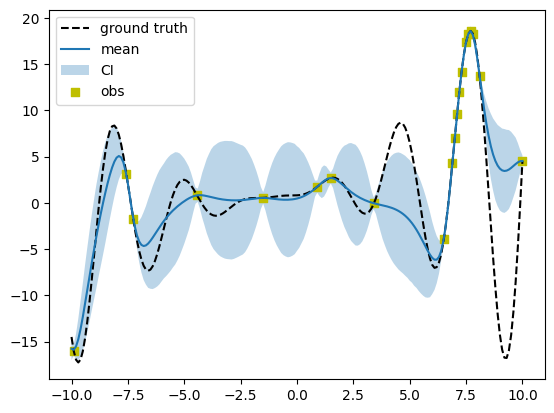

[170 171 172 173 175 178 177 181 176 200  68]


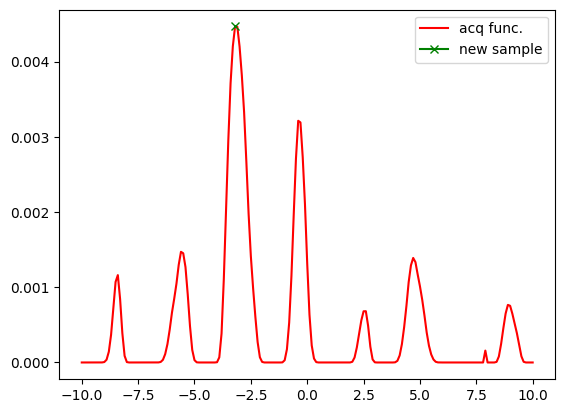

Step:12


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 147.96it/s, 3 steps of size 6.93e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.81      0.15      0.80      0.57      1.01    390.14      1.00
   k_scale     41.28     13.02     39.60     22.46     60.88    333.76      1.00
     noise      0.18      0.18      0.12      0.01      0.42    272.61      1.00



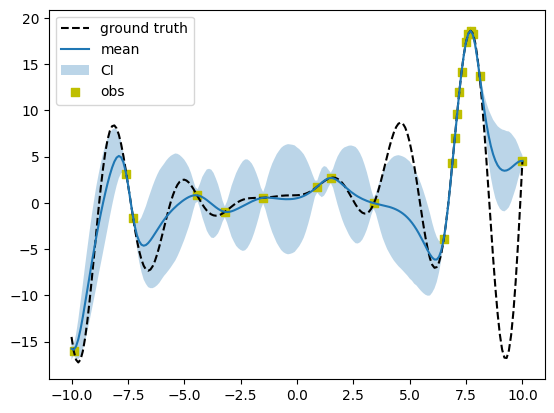

[170 171 172 173 175 178 177 181 176 200  68  97]


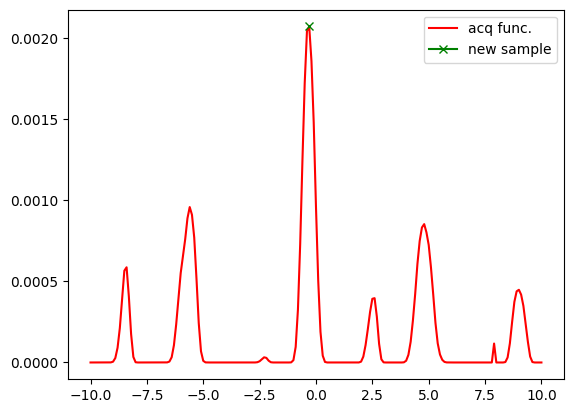

Step:13


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 147.31it/s, 7 steps of size 7.02e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.81      0.14      0.80      0.59      1.03    378.18      1.00
   k_scale     39.90     12.40     38.30     22.19     58.40    324.21      1.00
     noise      0.17      0.17      0.12      0.01      0.41    260.38      1.00



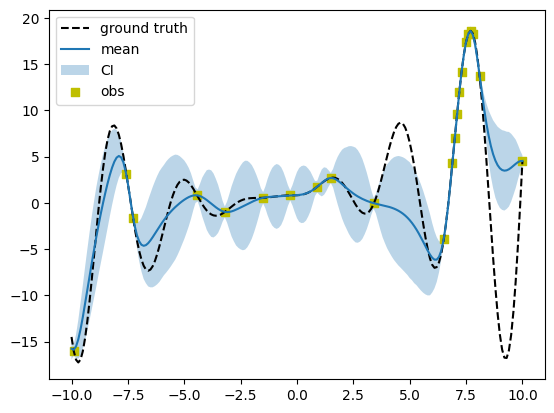

[170 171 172 173 175 178 177 181 176 200  68  97  44]


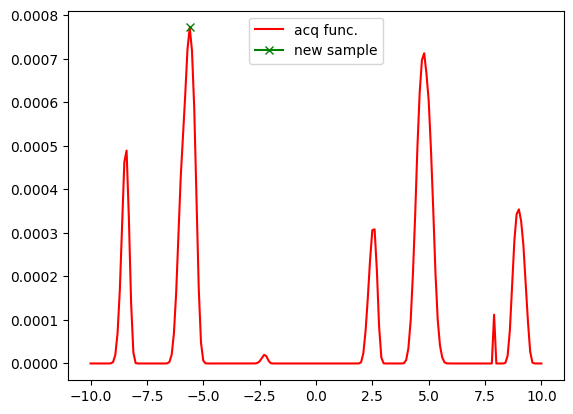

Step:14


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 147.82it/s, 7 steps of size 6.59e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.79      0.14      0.78      0.58      1.02    289.84      1.00
   k_scale     37.33     11.15     35.61     20.71     52.28    300.62      1.00
     noise      0.19      0.20      0.13      0.01      0.44    241.29      1.00



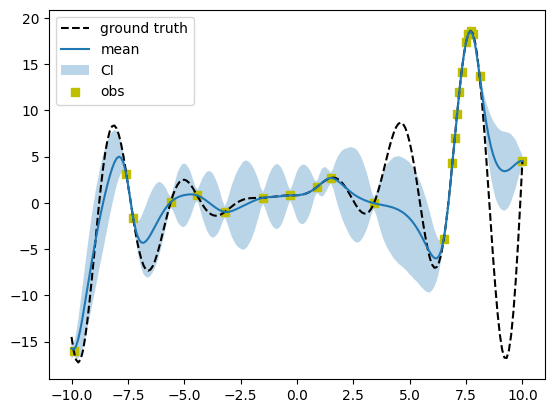

[170 171 172 173 175 178 177 181 176 200  68  97  44 147]


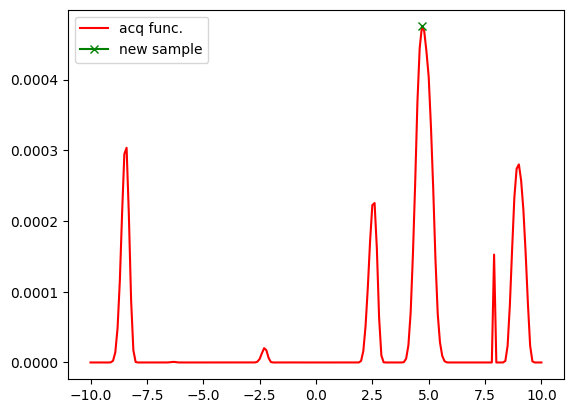

Step:15


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 147.50it/s, 7 steps of size 5.97e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.77      0.14      0.76      0.56      1.00    214.92      1.00
   k_scale     38.27     11.68     36.62     22.06     55.64    161.42      1.00
     noise      0.17      0.18      0.12      0.01      0.36    223.83      1.00



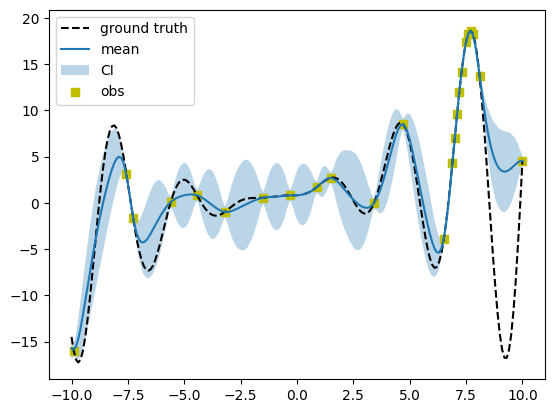

[170 171 172 173 175 178 177 181 176 200  68  97  44 147  16]


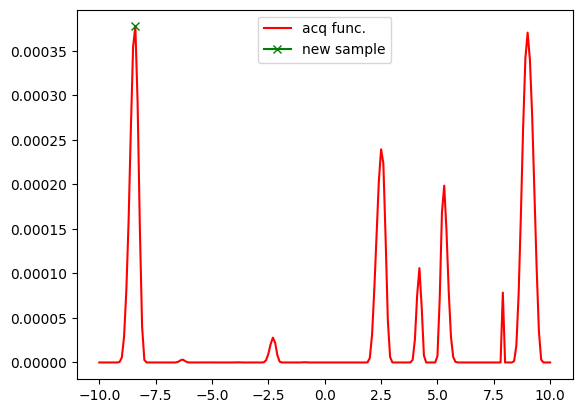

In [14]:
N = 15
X_test =xs
X_test_full = xs


# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
for i in range(1, N+1):
    print("Step:"+str(i))


    # Initialize model
    gp_model = gpax.ExactGP(1, kernel='Matern', kernel_prior = kernel_prior)
    # Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
    gp_model.fit(rng_key, train_x, train_y, num_warmup=500, num_samples=500, num_chains=1)

    y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test)
    plt.plot(xs, ys, "k--", label="ground truth")
    pred_lower = y_pred - y_sampled.std(axis=(0,1))
    pred_upper = y_pred + y_sampled.std(axis=(0,1))
    plt.plot(xs, y_pred, label="mean")
    plt.fill_between(
        xs.flatten(),
        pred_lower,
        pred_upper,
        alpha=0.3,
        label="CI",
    )
    plt.scatter(train_x, train_y, c="y", marker="s", label="obs")

    plt.legend(loc="best")
    plt.show()
    # Compute the EI acq function
    acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=True, noiseless=True)
    acq = np.array(acq)
    acq[idx] = 0
    next_point_val = acq.max()
    next_point_idx = acq.argmax()
    idx = np.hstack((idx, next_point_idx))

    if len(idx) == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)


    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
      # Data Augmentation
        next_point = X_test[next_point_idx]
        train_x = np.vstack((train_x, next_point))
        train_y = objective(train_x)

    #Plot acquistion function
    plt.plot(xs, acq, "r", label="acq func.")
    plt.plot(next_point, next_point_val, c="g", marker="x", label="new sample")
    plt.legend(loc="best")
    plt.show()


Reached the global optimal point at iteration 8 (total 18 samples)

# In case of Minimization

- Choosing the same initial point to start with

In [15]:
n = 10

np.random.seed(1000)
train_x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 1)
train_x

array([[ 3.07179171],
       [-7.69986114],
       [ 9.00565729],
       [-0.35617197],
       [ 7.4494907 ],
       [-5.75334638],
       [-9.1858075 ],
       [-2.05611077],
       [-5.33735605],
       [ 6.83481449]])

In [16]:
train_y = objective(train_x)
train_y

array([[ -1.15388528],
       [  5.07852259],
       [-14.36896225],
       [  0.80167406],
       [ 16.74453478],
       [ -1.28752985],
       [-10.3172209 ],
       [  0.50579859],
       [  1.78574992],
       [  2.80776181]])

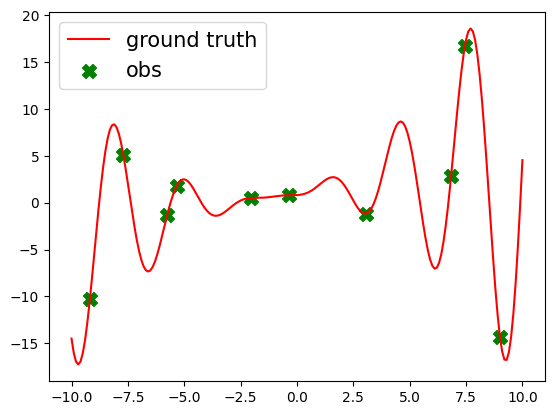

In [17]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.scatter(train_x, train_y, c="g", marker="X", label="obs", s=100)

plt.legend(fontsize=15);

# Run BO
-Here we are looking for minima point

In [18]:
def kernel_prior() -> Dict[str, jnp.ndarray]:
    length = numpyro.sample("k_length", numpyro.distributions.LogNormal(0, 1))
    scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
    return {"k_length": length, "k_scale": scale}

Step:1


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:08<00:00, 116.40it/s, 7 steps of size 1.42e-01. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.25      1.47      0.75      0.05      2.86     80.89      1.00
   k_scale      7.80     15.16      1.53      0.09     32.59     30.80      1.00
     noise     33.67     19.62     33.37      0.07     58.93     39.15      1.01



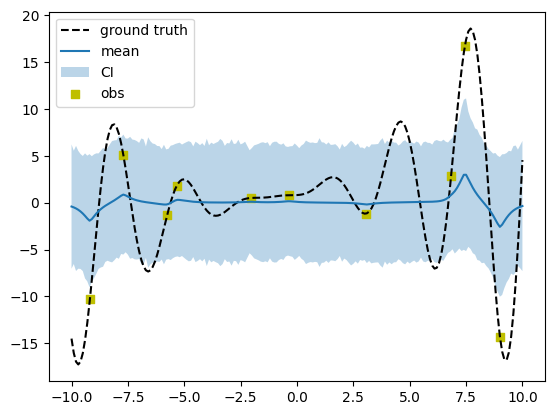

190


<ipython-input-19-2a7b755ac4e4>:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx = int(idx)


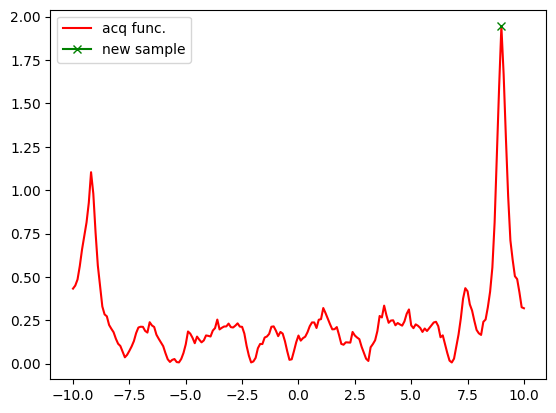

/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(


Step:2


sample: 100%|██████████| 1000/1000 [00:06<00:00, 163.69it/s, 7 steps of size 7.34e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.39      0.18      0.37      0.09      0.61    147.80      1.00
   k_scale     40.21     14.17     38.65     18.13     61.71    170.18      1.00
     noise      2.57     12.02      0.67      0.05      2.88     68.80      1.01



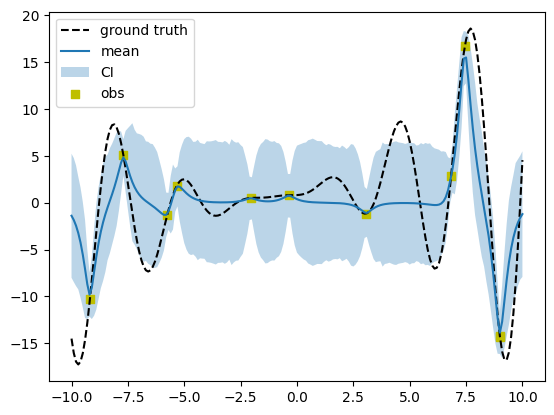

[190 191]


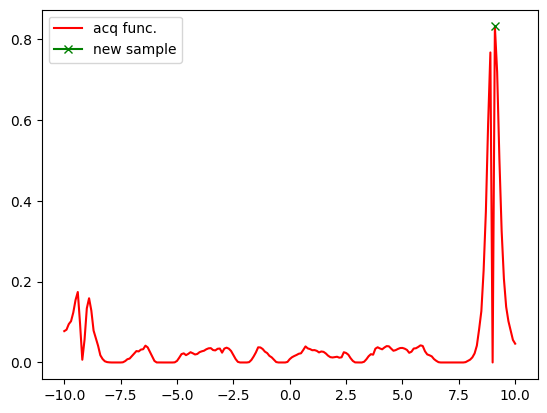

Step:3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:05<00:00, 167.32it/s, 3 steps of size 7.59e-01. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.45      0.16      0.44      0.21      0.69    330.40      1.00
   k_scale     43.43     15.74     40.40     21.44     69.79    378.34      1.00
     noise      0.97      1.09      0.59      0.04      2.20    354.59      1.00



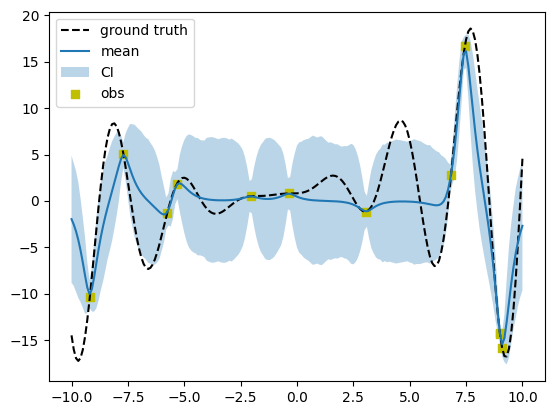

[190 191 193]


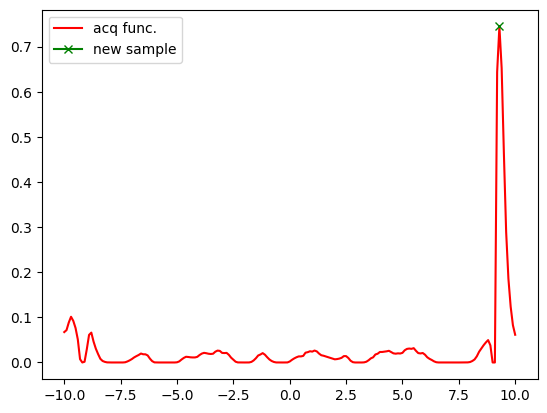

Step:4


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 156.98it/s, 3 steps of size 7.68e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.53      0.15      0.53      0.29      0.77    280.24      1.00
   k_scale     44.82     15.46     42.48     23.28     67.33    423.31      1.00
     noise      0.81      0.87      0.52      0.03      1.84    319.28      1.00



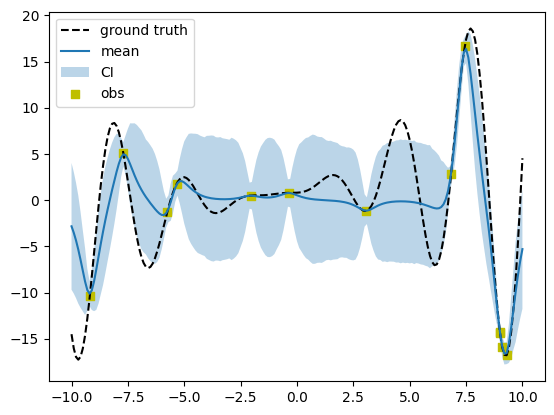

[190 191 193 192]


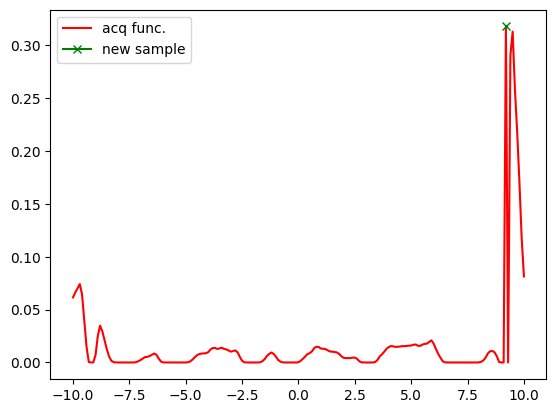

Step:5


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 161.55it/s, 7 steps of size 6.68e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.55      0.14      0.55      0.30      0.75    358.47      1.00
   k_scale     44.40     15.26     42.28     21.11     61.19    353.84      1.00
     noise      0.55      0.66      0.35      0.02      1.25    375.29      1.00



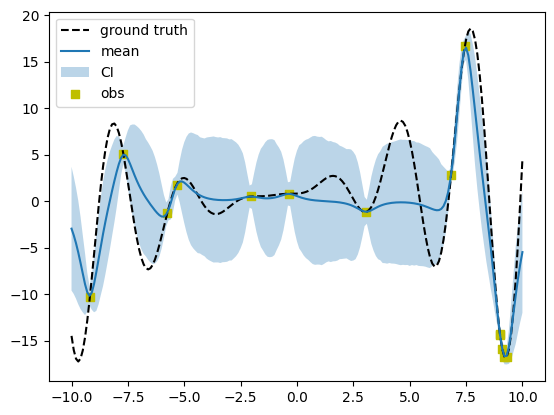

[190 191 193 192 195]


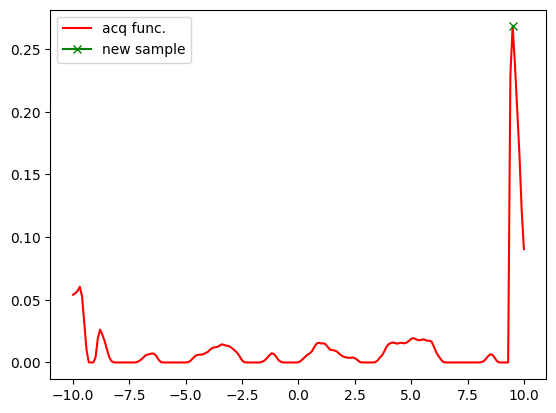

Step:6


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 161.69it/s, 7 steps of size 7.12e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.58      0.14      0.58      0.36      0.78    213.91      1.00
   k_scale     45.96     16.00     42.53     22.53     70.90    266.83      1.00
     noise      0.42      0.41      0.27      0.04      0.91    356.11      1.00



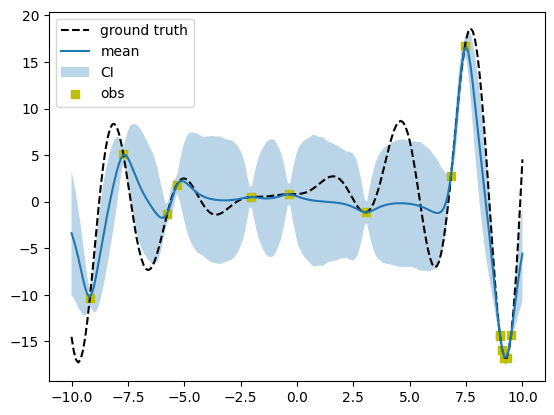

[190 191 193 192 195   1]


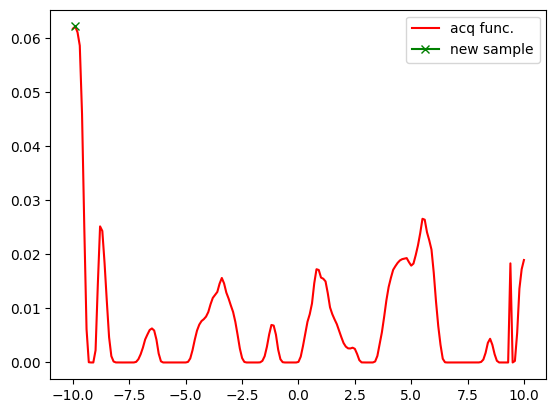

Step:7


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 158.33it/s, 7 steps of size 6.61e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.64      0.15      0.63      0.41      0.88    327.20      1.00
   k_scale     51.60     17.13     48.41     26.04     75.84    287.05      1.00
     noise      0.43      0.42      0.30      0.04      0.99    251.67      1.00



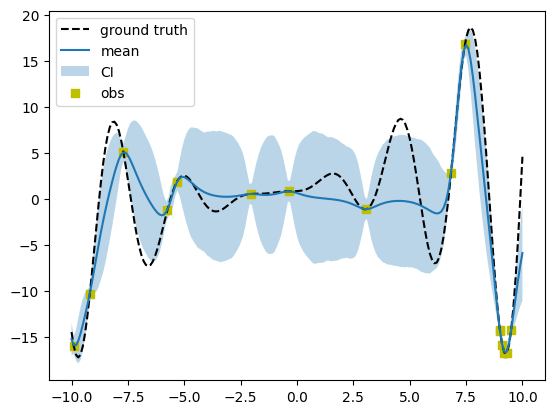

[190 191 193 192 195   1   3]


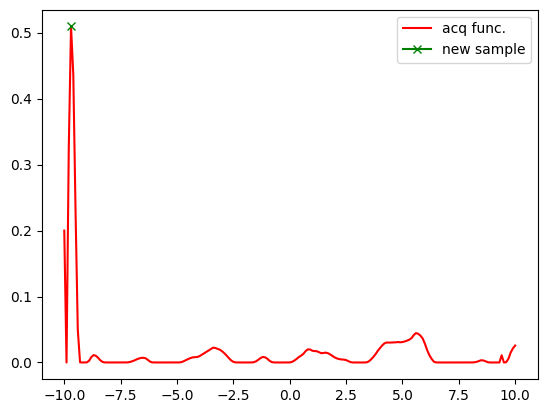

Step:8


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 150.13it/s, 3 steps of size 7.80e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.65      0.13      0.65      0.44      0.84    341.20      1.00
   k_scale     51.87     16.57     49.92     28.45     77.11    407.10      1.00
     noise      0.42      0.44      0.27      0.03      0.96    325.54      1.02



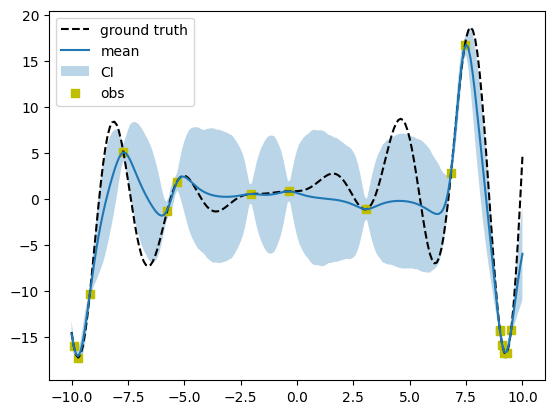

[190 191 193 192 195   1   3   4]


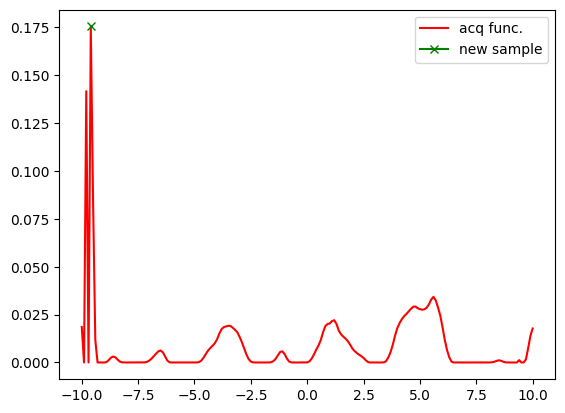

Step:9


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 145.73it/s, 3 steps of size 6.21e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.67      0.13      0.66      0.47      0.90    299.09      1.00
   k_scale     51.15     18.10     47.18     26.21     73.51    271.59      1.00
     noise      0.31      0.31      0.22      0.02      0.70    252.37      1.00



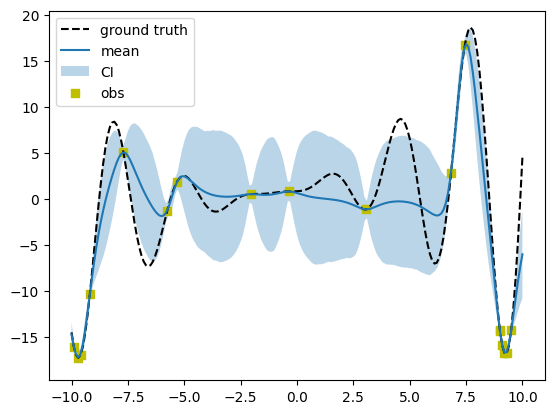

[190 191 193 192 195   1   3   4   2]


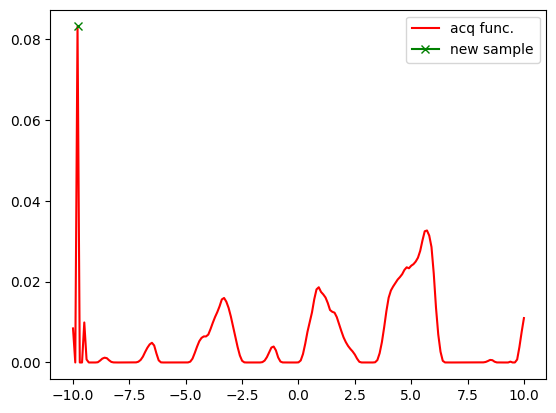

Step:10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:07<00:00, 141.74it/s, 5 steps of size 6.42e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.68      0.12      0.68      0.49      0.87    225.93      1.00
   k_scale     50.67     16.65     47.31     28.78     78.86    234.43      1.00
     noise      0.23      0.22      0.16      0.01      0.49    261.85      1.00



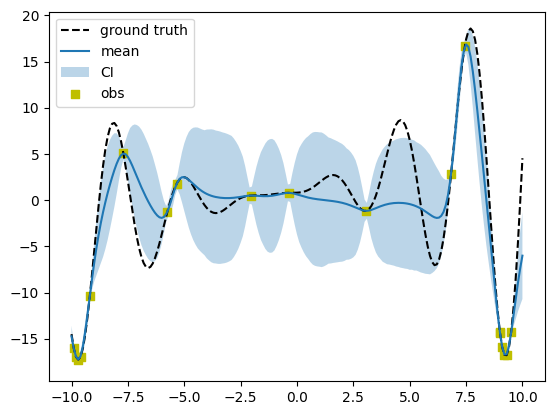

[190 191 193 192 195   1   3   4   2 156]


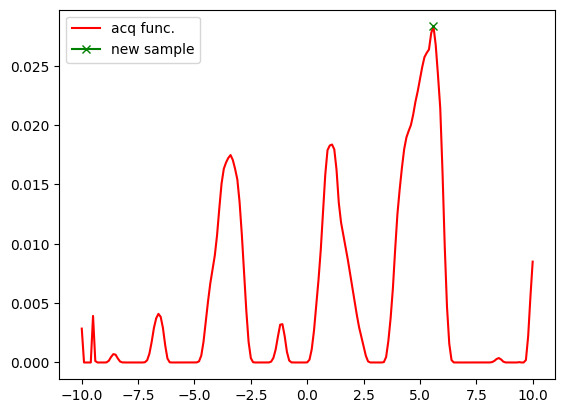

Step:11


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 148.85it/s, 7 steps of size 6.80e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.69      0.12      0.68      0.48      0.87    206.88      1.00
   k_scale     48.92     15.75     46.45     26.74     70.10    201.20      1.00
     noise      0.22      0.25      0.14      0.01      0.55    230.01      1.00



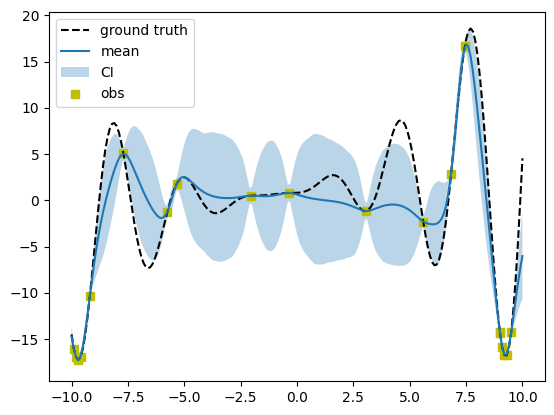

[190 191 193 192 195   1   3   4   2 156 109]


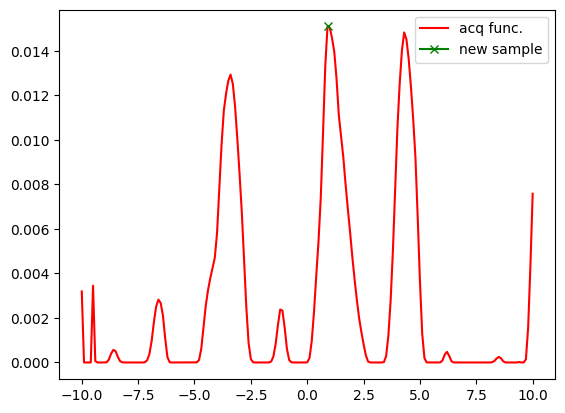

Step:12


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:07<00:00, 141.08it/s, 3 steps of size 6.06e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.68      0.12      0.67      0.48      0.88    320.03      1.00
   k_scale     47.19     14.99     44.41     26.08     67.87    305.19      1.00
     noise      0.22      0.22      0.15      0.01      0.50    331.84      1.00



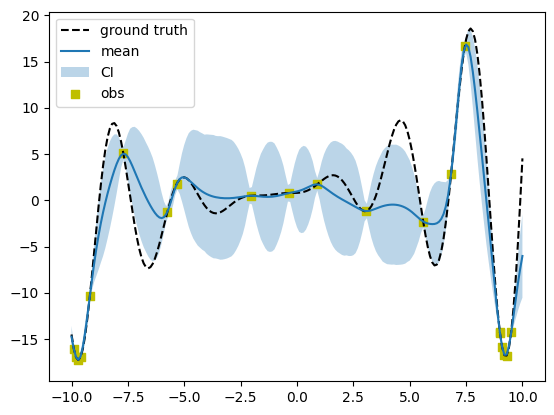

[190 191 193 192 195   1   3   4   2 156 109 143]


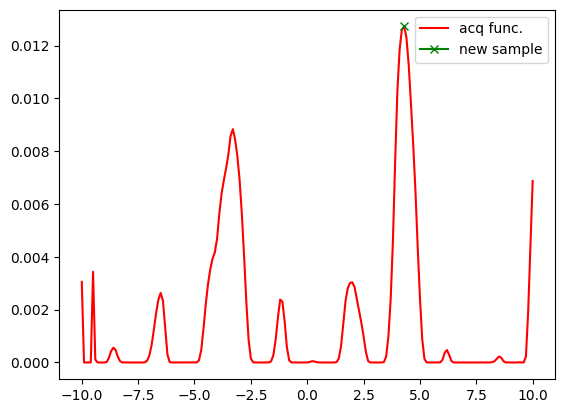

Step:13


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:07<00:00, 141.01it/s, 3 steps of size 6.25e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.67      0.11      0.67      0.49      0.85    374.23      1.00
   k_scale     47.48     15.65     44.94     25.66     66.67    255.28      1.00
     noise      0.22      0.22      0.16      0.01      0.47    318.20      1.00



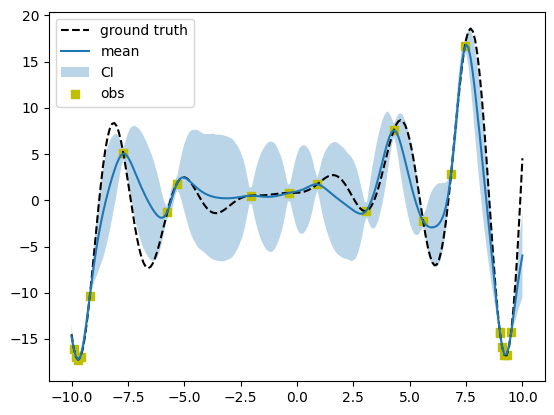

[190 191 193 192 195   1   3   4   2 156 109 143  67]


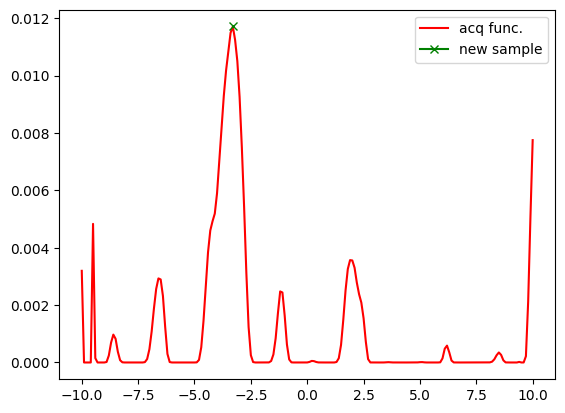

Step:14


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 144.91it/s, 3 steps of size 6.35e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.67      0.12      0.67      0.48      0.86    336.87      1.00
   k_scale     45.38     13.21     43.27     25.56     65.63    407.55      1.00
     noise      0.24      0.23      0.16      0.01      0.53    275.12      1.00



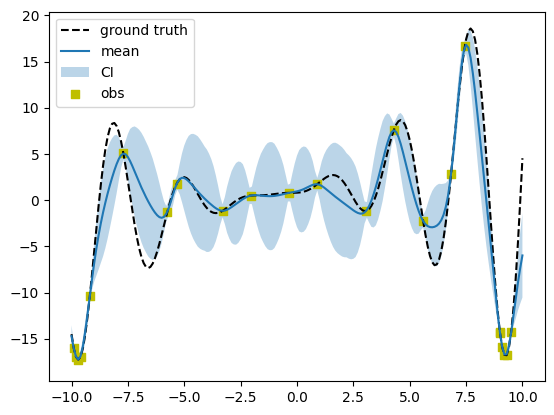

[190 191 193 192 195   1   3   4   2 156 109 143  67 200]


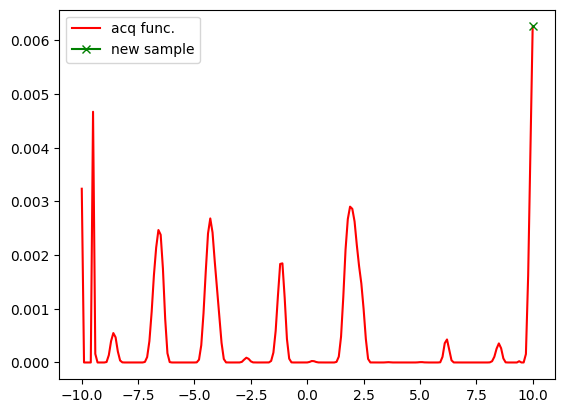

Step:15


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 147.55it/s, 7 steps of size 6.84e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.59      0.11      0.58      0.44      0.78    306.33      1.00
   k_scale     49.04     14.90     46.28     29.09     70.53    256.54      1.00
     noise      0.25      0.27      0.17      0.01      0.55    270.83      1.00



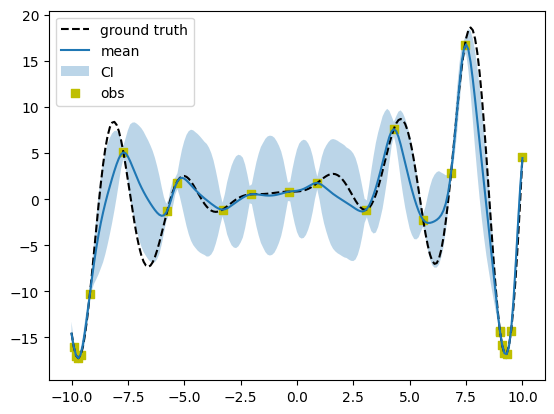

[190 191 193 192 195   1   3   4   2 156 109 143  67 200   5]


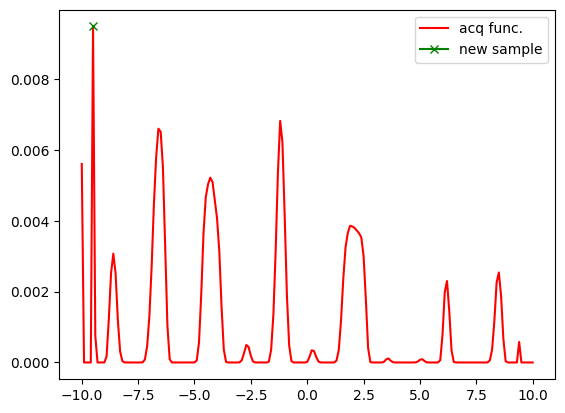

In [19]:
N = 15
X_test =xs
X_test_full = xs


# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
for i in range(1, N+1):
    print("Step:"+str(i))


    # Initialize model
    gp_model = gpax.ExactGP(1, kernel='Matern', kernel_prior = kernel_prior)
    # Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
    gp_model.fit(rng_key, train_x, train_y, num_warmup=500, num_samples=500, num_chains=1)

    y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test)
    plt.plot(xs, ys, "k--", label="ground truth")
    pred_lower = y_pred - y_sampled.std(axis=(0,1))
    pred_upper = y_pred + y_sampled.std(axis=(0,1))
    plt.plot(xs, y_pred, label="mean")
    plt.fill_between(
        xs.flatten(),
        pred_lower,
        pred_upper,
        alpha=0.3,
        label="CI",
    )
    plt.scatter(train_x, train_y, c="y", marker="s", label="obs")

    plt.legend(loc="best")
    plt.show()
    # Compute the EI acq function
    acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=False, noiseless=True)
    acq = np.array(acq)
    acq[idx] = 0
    next_point_val = acq.max()
    next_point_idx = acq.argmax()
    idx = np.hstack((idx, next_point_idx))

    if len(idx) == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)


    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
      # Data Augmentation
        next_point = X_test[next_point_idx]
        train_x = np.vstack((train_x, next_point))
        train_y = objective(train_x)

    #Plot acquistion function
    plt.plot(xs, acq, "r", label="acq func.")
    plt.plot(next_point, next_point_val, c="g", marker="x", label="new sample")
    plt.legend(loc="best")
    plt.show()


Reached both the global optimal points at iteration 7 (total 17 samples)

In [20]:
#@title Problem 2: Ising model
class IsingSim():

  """This class performs Ising model simulations on a 2D grid. Interaction parameters are given by a matrix at each lattice site.
  Field dependence is not supported at this time but will be in due course. The simulator outputs configurations after equlibrium
  as well as the trajectories, if specifically requested.
  Inputs:
    - N : (integer) - Size of lattice will be N^2. Only 2D square lattice is supported at this stage.
    - J_mat: (numpy matrix of shape(5,5)) - entries being floats for interaction parameters. Self-interaction (middle element of matrix)=0.
    - T: (float) - Reduced temperature for simulation
    - save_trajectories: (Boolean) - whether to save trajectories, or only final state. Default False.
    - eqSteps: (integer) number of Monte-Carlo steps for equlibration before simulation starts. Default 750. AKA 'burn-in'.
    - mcSteps: (integer) number of Monte-Carlo for simulation. Default 750.
  Outputs: Several outputs are available, including trajectories (if called), configurations (i.e., the 2D states) and configurations histograms.
  These can be obtained by calling methods self.configurations(), self.histograms() and self.trajectories()"""

  def __init__(self, N = 40, J_mat = None, T = 2.7, save_trajectories = False,
               eqSteps = 750, mcSteps = 750):
    self.N = N

    #If no J matrix is provided we default to isotropic J interaction with NN with value 0.5
    if np.array(J_mat).all() == None:
      J_mat = np.zeros((5,5))
      J_mat[1,2] = J_mat[2,1] = J_mat[2,3] = J_mat[3,2] = 0.5 #Defaulting to 0.5 for NN, all others zeroed out.

    self.J_mat = J_mat

    self.save_trajectories = save_trajectories
    self.eqSteps = eqSteps
    self.mcSteps = mcSteps
    self.config = self.initialState(random = False)
    self.T = T

  def initialState(self, random = False):
    ''' Generates a lattice with spin configurations drawn randomly [-1 or 1] if random=True
    Else, the lattice is generated with all sites = 1 '''

    if random==True: state = 2*np.random.randint(2, size=(self.N,self.N))-1
    else: state = np.ones([self.N,self.N])

    return state

  def mcmove(self, config):
    '''Monte Carlo move using Metropolis algorithm '''

    M = 5 #neighborhood size (M^2). Do not change!
    beta = 1.0/self.T

    for i in range(self.N):
      for j in range(self.N):
        J_mat = self.J_mat
        cost = 0.0
        s =  np.copy(config[i, j])

        for p in range(-int(M/2), int(M/2)+1, 1):
          for q in range(-int(M/2), int(M/2)+1, 1):
            cost += 2 * J_mat[int(M/2)+p, int(M/2)+q] * config[(i+p)%self.N,(j+q)%self.N] * config[i,j]

        if cost < 0:
          s *= -1
        elif rand() < np.exp(-cost*beta):
          s *= -1
        config[i, j] = s
    return config


  def calcEnergy(self, config):
    '''Returns the energy of the current configuration'''
    M = 5
    energy = 0.0
    for i in range(len(config)):
      for j in range(len(config)):
        J_mat = self.J_mat #otherwise, no

        s = config[i,j]
        for p in range(-int(M/2), int(M/2)+1, 1):
          for q in range(-int(M/2), int(M/2)+1, 1):
            energy += -J_mat[int(M/2)+p, int(M/2)+q] * config[(i+p)%self.N,(j+q)%self.N] * config[i,j]

    return energy/4.0


  def calcMag(self, config):
    '''Magnetization of a given configuration'''
    return np.sum(config)

  def calcAbsMag(self, config):
    ''' Absolute Magnetization of a given configuration'''
    return (np.abs(np.sum(config)))*1.0

  def performIsingSim(self):

    E1, M1, E2, M2 = 0.0,0.0,0.0,0.0    #These are all the average properties of all MC steps used
    E_traj, M_traj = np.zeros(self.mcSteps), np.zeros(self.mcSteps)

    config = np.copy(self.config)
    T = self.T
    if self.save_trajectories: config_mat = np.zeros([self.mcSteps,self.N,self.N])   #Saving all the configurations


    print('\n---Performing Equlibration---\n')
    for i in tqdm(range(self.eqSteps)):
        config = self.mcmove(config)

    print('\n---Finished...\n----Performing MC Moves----\n')
    for j in tqdm(range(self.mcSteps)):
        config = self.mcmove(config)
        Ene, Mag = self.calcEnergy(config), self.calcAbsMag(config)
        E_traj[j] = self.calcEnergy(config)/(self.N*self.N)
        M_traj[j] = self.calcAbsMag(config)/(self.N*self.N)

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag * Mag
        E2 = E2 + Ene * Ene

        if self.save_trajectories: config_mat[j] = config

    print('Completed. Saving')
    Energy = E1 / (self.mcSteps * self.N * self.N)
    Magnetization = M1 / (self.mcSteps * self.N * self.N)
    n1, n2  = 1.0/(self.mcSteps*self.N*self.N), 1.0/(self.mcSteps*self.mcSteps*self.N*self.N)
    iT = 1.0/self.T
    iT2 = iT*iT
    SpecificHeat = (n1*E2 - n2*E1*E1)*iT2
    Susceptibility = (n1*M2 - n2*M1*M1)*iT
    # SpecificHeat = (E2 / self.mcSteps - E1 * E1 / (self.mcSteps * self.mcSteps)) / (self.N * self.T * self.T)
    # Susceptibility = (M2 / self.mcSteps - M1 * M1 / (self.mcSteps * self.mcSteps)) / (self.N * self.T)

    self.config = config


    if self.save_trajectories:
      results_dict = {'config': config_mat, 'Energy': Energy, 'Magnetization': Magnetization,
      'SpecificHeat': SpecificHeat, 'Susceptibility': Susceptibility, 'E_traj': E_traj,
      'M_traj': M_traj,
      }
    else:
      results_dict = {'Energy': Energy, 'Magnetization': Magnetization,
      'SpecificHeat': SpecificHeat, 'Susceptibility': Susceptibility,
      'E_traj': E_traj, 'M_traj': M_traj,}

    self.results = results_dict

    return 'Completed simulation'

# Defining parameter space and grid points

In [21]:
lb = 0
ub = 3
N_total = 201
bounds = np.array((lb, ub), dtype=float)
fidelities = np.array((0.95, 1.0))

xs = np.linspace(lb, ub, N_total)
xs_norm = (xs-lb)/(ub-lb)

# Load Groung truth data

- 20x20 Ising model simulation

In [22]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#results_dict_square = np.load("/content/gdrive/MyDrive/Colab Notebooks/sMFBO/results_dict_square.npy", allow_pickle=True)
#results_dict_square = dict(enumerate(results_dict_square.flatten(), 1))


In [23]:
!gdown https://drive.google.com/uc?id=15WdrsmIsAOSD5SaU5OMmdZAhucisKQHF
results_dict_square = np.load("results_dict_square.npy", allow_pickle=True)
results_dict_square = dict(enumerate(results_dict_square.flatten(), 1))



Downloading...
From (original): https://drive.google.com/uc?id=15WdrsmIsAOSD5SaU5OMmdZAhucisKQHF
From (redirected): https://drive.google.com/uc?id=15WdrsmIsAOSD5SaU5OMmdZAhucisKQHF&confirm=t&uuid=c2de2e71-1f49-4ed9-ac1f-5194b143b758
To: /content/results_dict_square.npy
100% 323M/323M [00:03<00:00, 94.3MB/s]


In [24]:
true_ys_sq = np.zeros(xs.shape[0])
for i in range(0, xs.shape[0]):
    true_ys_sq[i] = results_dict_square[1][i]['sim']['SpecificHeat']


# Plot ground truth - Ising model with lattice size 20

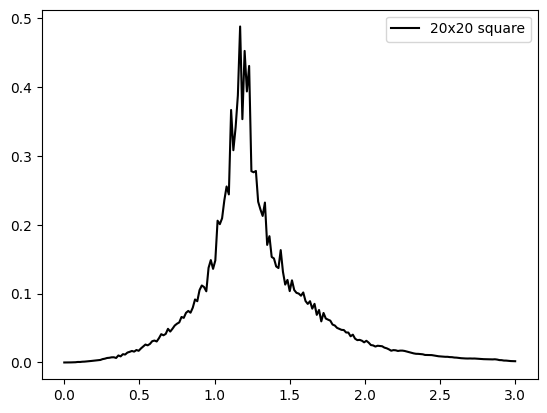

In [25]:

plt.plot(xs, true_ys_sq, "k", label="20x20 square")
plt.legend(loc="best")

In [26]:
np.argmax(true_ys_sq)
xs[np.argmax(true_ys_sq)]

1.17

# Bayesian Optimization

- Maximize the heat capacity

Initial Sampling- 10 samples

In [27]:
n = 5

np.random.seed(10)
train_x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 1)
train_x_norm = (train_x-bounds[0])/(bounds[1]-bounds[0])
train_x_full = train_x
train_x_full_norm = train_x_norm
train_x_full, train_x_full_norm

(array([[2.31396193],
        [0.06225585],
        [1.9009447 ],
        [2.24641165],
        [1.49552104]]),
 array([[0.77132064],
        [0.02075195],
        [0.63364823],
        [0.74880388],
        [0.49850701]]))

Evaluation 1 of 5

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 72.88it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 28.20it/s]


Completed. Saving
Time (s) to complete simulation 1: 24.59894561767578


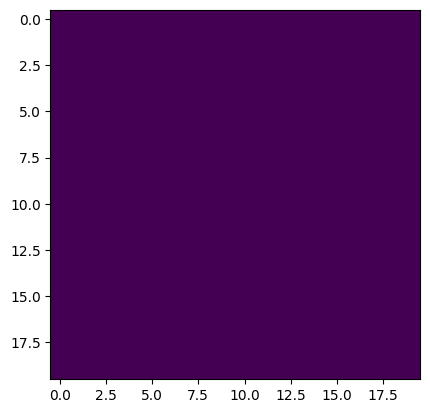

Evaluation 2 of 5

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 72.17it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 29.52it/s]


Completed. Saving
Time (s) to complete simulation 2: 23.874858617782593


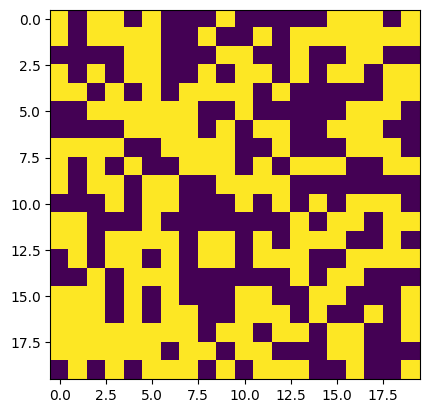

Evaluation 3 of 5

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 77.80it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 30.13it/s]


Completed. Saving
Time (s) to complete simulation 3: 23.026851892471313


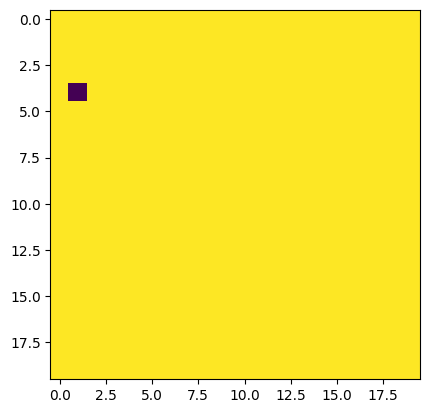

Evaluation 4 of 5

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 80.33it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 30.17it/s]


Completed. Saving
Time (s) to complete simulation 4: 22.807353496551514


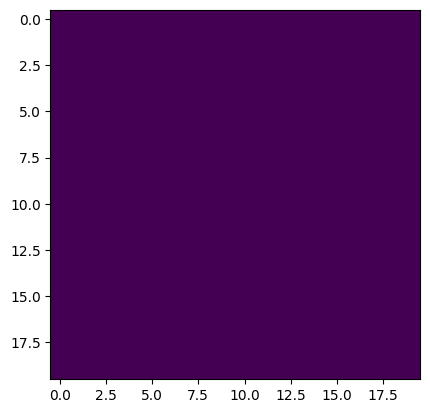

Evaluation 5 of 5

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 79.84it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 30.22it/s]


Completed. Saving
Time (s) to complete simulation 5: 22.81720733642578


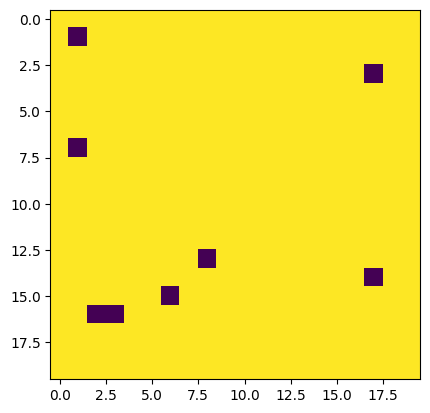

In [28]:
train_y = np.zeros(train_x.shape)
Jx=train_x
resultsBO_dict = {}
for i in range(0, train_x.shape[0]):
    J_mat = np.array([[0,0,0,0,0],
                      [0,0,Jx[i, 0],0,0],
                      [0,Jx[i, 0],0,Jx[i, 0],0],
                      [0,0,Jx[i, 0],0,0],
                      [0,0,0,0,0]])
    print("Evaluation " +str (i+1) +" of " +str(n))
    start_time = time.time()
    np.random.seed(0)
    sq_sim = IsingSim(N = 20, J_mat = J_mat, T = 2.7, save_trajectories=True, eqSteps = 500, mcSteps = 500)  # Intializing the object

    sq_sim.performIsingSim()   # Running the sim
    end_time = time.time()
    #time_eval[i]= end_time-start_time
    print("Time (s) to complete simulation " +str(i+1)+ ": " +str(end_time-start_time))
    resultsBO_dict[i] = {'sim': sq_sim.results,}
    train_y[i] = resultsBO_dict[i]['sim']['SpecificHeat']
    plt.imshow(resultsBO_dict[i]['sim']['config'][-1])
    plt.show()

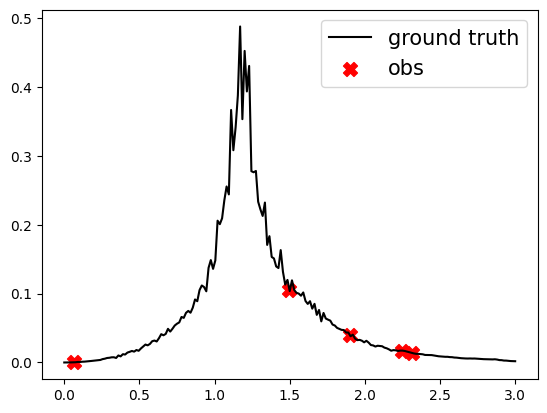

In [62]:
plt.plot(xs, true_ys_sq, "k", label="ground truth")

plt.scatter(train_x, train_y, c="r", marker="X", label="obs", s=100)

plt.legend(fontsize=15);

In [ ]:
#train_x_full = train_x_full[0:n]
#train_x_full_norm = train_x_full_norm[0:n]
#train_y = train_y[0:n]
#train_x_full, train_x_full_norm, train_y

# Define GP prior distribution

In [49]:
def kernel_prior() -> Dict[str, jnp.ndarray]:
    length = numpyro.sample("k_length", numpyro.distributions.Uniform(0.01, 1))
    scale = numpyro.sample("k_scale", numpyro.distributions.Uniform(0.01, 1))
    return {"k_length": length, "k_scale": scale}

In [61]:
train_x_full = train_x_full[0:n]
train_x_full_norm = train_x_full_norm[0:n]
train_y = train_y[0:n]
train_x_full, train_x_full_norm, train_y

(array([[2.31396193],
        [0.06225585],
        [1.9009447 ],
        [2.24641165],
        [1.49552104]]),
 array([[0.77132064],
        [0.02075195],
        [0.63364823],
        [0.74880388],
        [0.49850701]]),
 array([[0.01413402],
        [0.00039374],
        [0.03967774],
        [0.01734454],
        [0.10521883]]))

# Run BO

Step:1


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 156.27it/s, 7 steps of size 5.42e-01. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.63      0.24      0.65      0.28      0.99    327.76      1.00
   k_scale      0.17      0.21      0.07      0.01      0.48    243.58      1.00
     noise      0.01      0.01      0.00      0.00      0.02    328.61      1.00



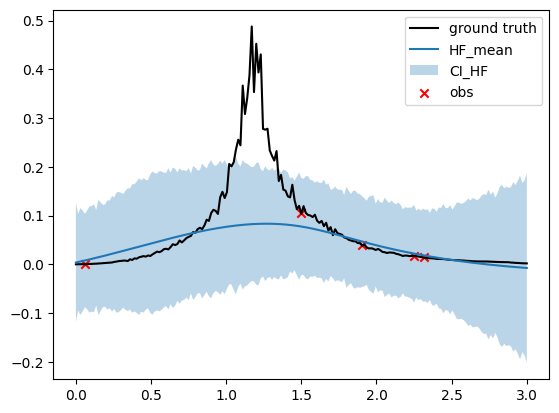

60


<ipython-input-63-d4201196c20c>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx = int(idx)


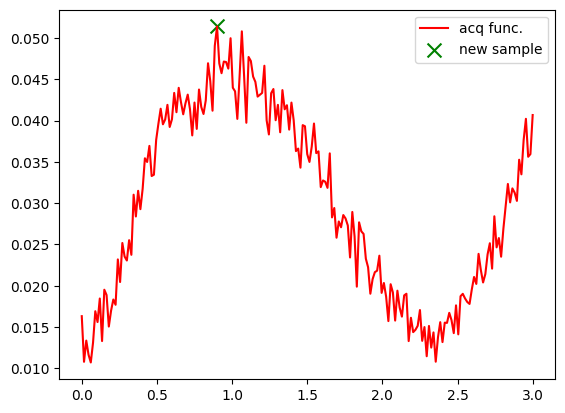

0.8999999999999999 0.8999999999999999
Evaluation 6 of 15

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 74.26it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 29.57it/s]


Completed. Saving
Time (s) to complete simulation 2: 23.6515109539032


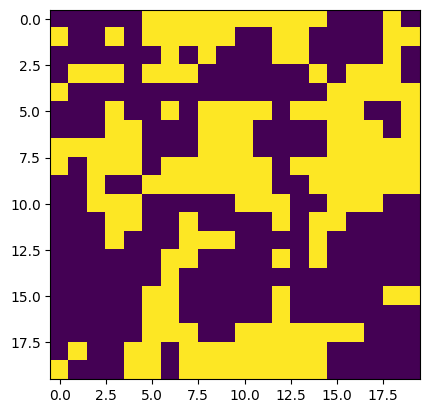

Step:2


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 150.04it/s, 7 steps of size 4.90e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.68      0.20      0.70      0.39      1.00    407.87      1.00
   k_scale      0.15      0.19      0.07      0.01      0.36    196.08      1.00
     noise      0.00      0.01      0.00      0.00      0.01    341.89      1.00



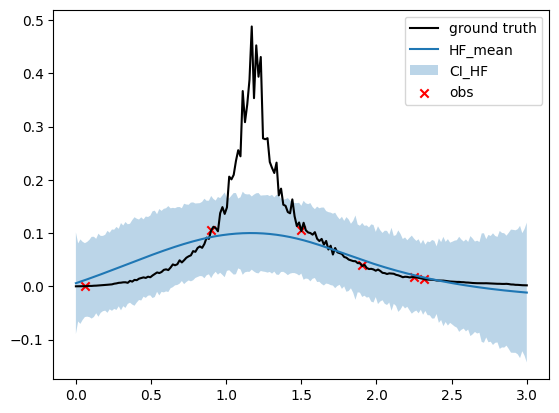

[60 66]


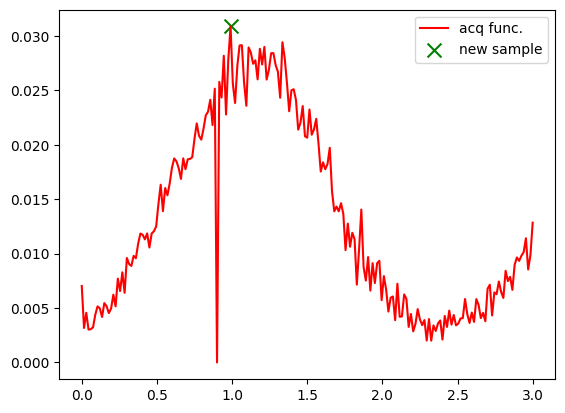

0.99 0.99
Evaluation 7 of 15

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 73.32it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 29.79it/s]


Completed. Saving
Time (s) to complete simulation 3: 23.61072611808777


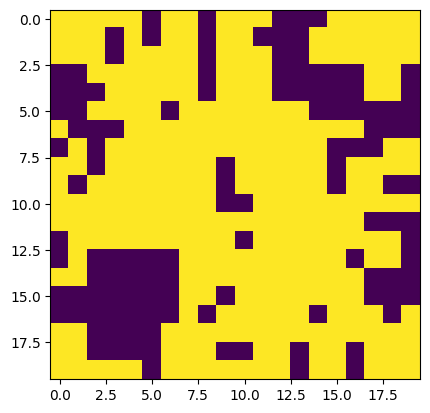

Step:3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 147.25it/s, 7 steps of size 4.63e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.67      0.21      0.70      0.37      1.00    406.86      1.00
   k_scale      0.15      0.17      0.08      0.01      0.38    362.71      1.00
     noise      0.00      0.00      0.00      0.00      0.00    153.10      1.01



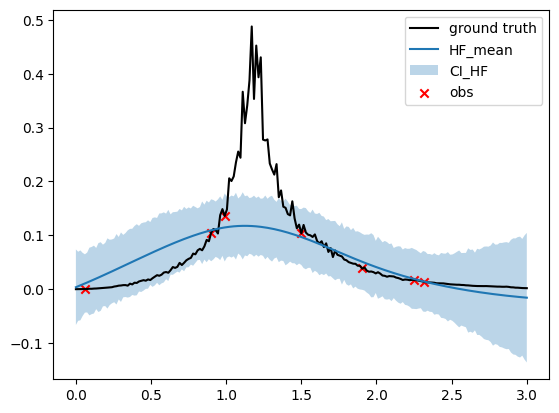

[60 66 71]


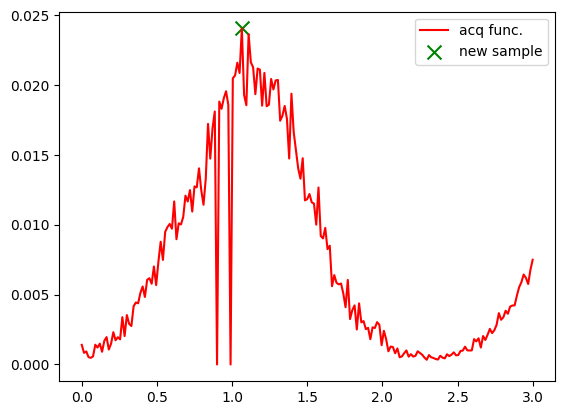

1.065 1.065
Evaluation 8 of 15

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 76.76it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 30.01it/s]


Completed. Saving
Time (s) to complete simulation 4: 23.180619955062866


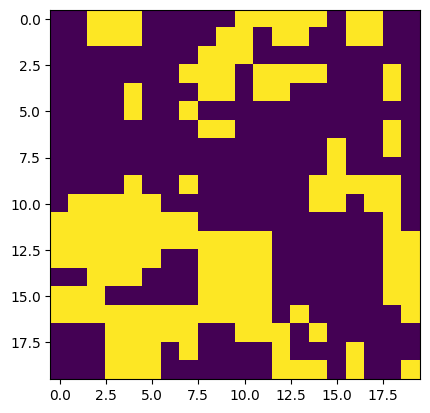

Step:4


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 158.80it/s, 7 steps of size 5.76e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.60      0.23      0.64      0.28      0.99    413.23      1.00
   k_scale      0.18      0.21      0.10      0.01      0.50    344.62      1.00
     noise      0.01      0.01      0.00      0.00      0.01    230.92      1.00



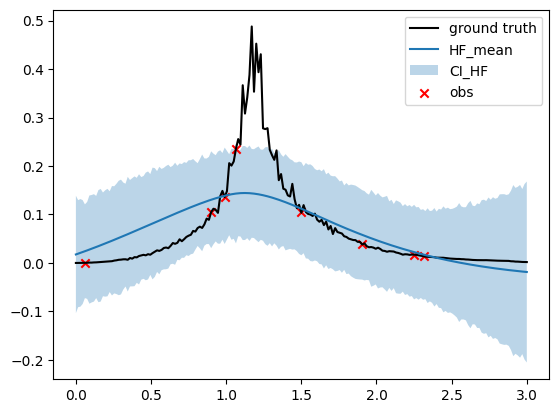

[60 66 71 74]


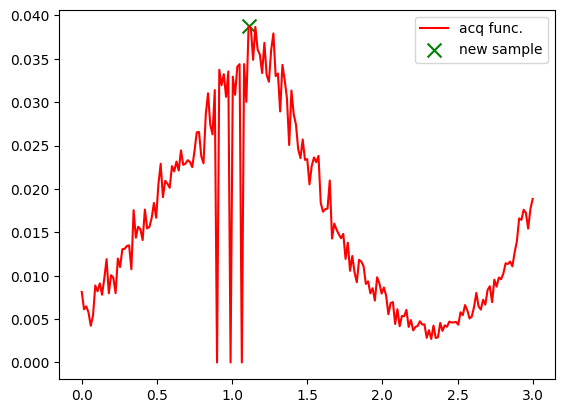

1.1099999999999999 1.1099999999999999
Evaluation 9 of 15

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 75.71it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 30.04it/s]


Completed. Saving
Time (s) to complete simulation 5: 23.254994869232178


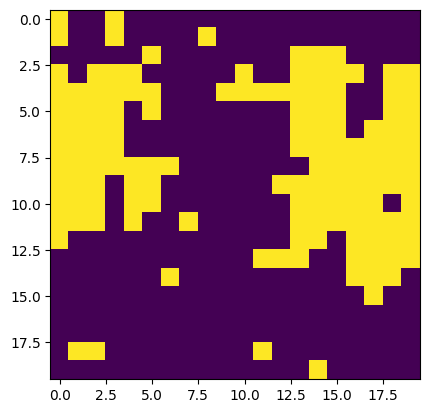

Step:5


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:06<00:00, 148.94it/s, 7 steps of size 5.79e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.57      0.25      0.59      0.20      0.99    343.71      1.01
   k_scale      0.21      0.21      0.13      0.01      0.55    264.23      1.00
     noise      0.01      0.01      0.01      0.00      0.03    250.27      1.00



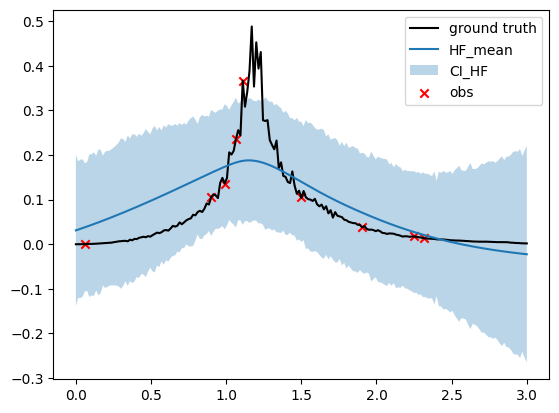

[60 66 71 74 77]


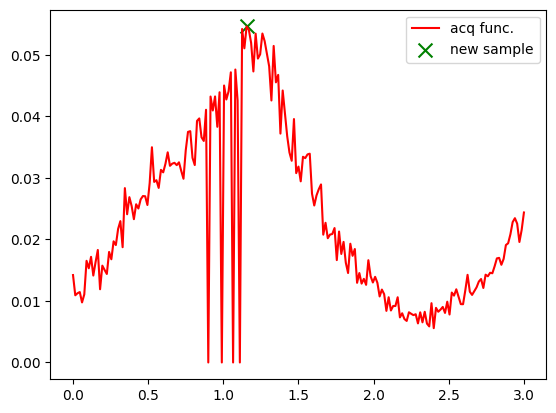

1.155 1.155
Evaluation 10 of 15

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 75.63it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 30.01it/s]


Completed. Saving
Time (s) to complete simulation 6: 23.282499313354492


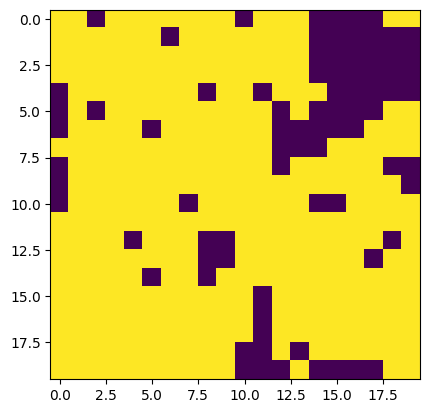

Step:6


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:07<00:00, 135.69it/s, 7 steps of size 4.64e-01. acc. prob=0.80]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.44      0.27      0.40      0.06      0.86     90.60      1.00
   k_scale      0.22      0.22      0.14      0.01      0.60    294.21      1.00
     noise      0.01      0.01      0.01      0.00      0.03     74.29      1.00



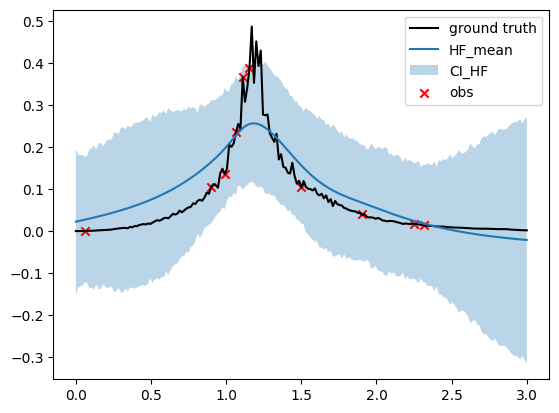

[60 66 71 74 77 81]


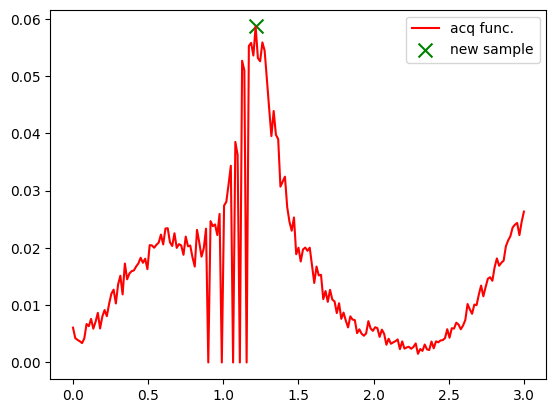

1.2149999999999999 1.2149999999999999
Evaluation 11 of 15

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 76.84it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 29.92it/s]


Completed. Saving
Time (s) to complete simulation 7: 23.2301185131073


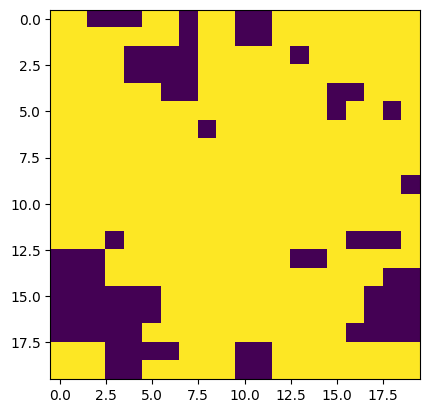

Step:7


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:08<00:00, 116.88it/s, 15 steps of size 2.85e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.29      0.24      0.18      0.04      0.70     99.54      1.00
   k_scale      0.18      0.20      0.09      0.01      0.48    178.92      1.01
     noise      0.01      0.01      0.01      0.00      0.02    125.07      1.01



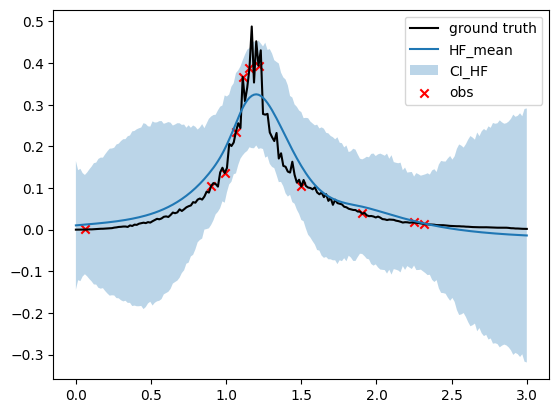

[60 66 71 74 77 81 79]


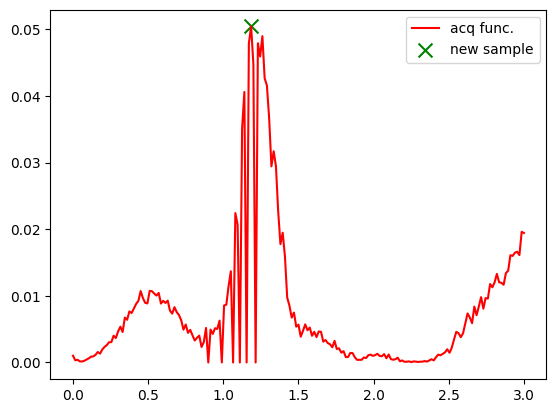

1.185 1.185
Evaluation 12 of 15

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 76.87it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 29.75it/s]


Completed. Saving
Time (s) to complete simulation 8: 23.32332491874695


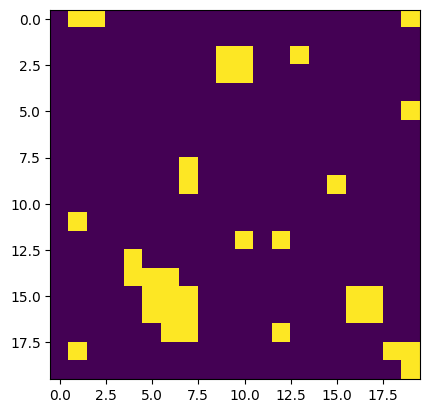

Step:8


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:08<00:00, 114.01it/s, 15 steps of size 2.10e-01. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.24      0.22      0.15      0.03      0.62     99.07      1.00
   k_scale      0.16      0.20      0.08      0.01      0.44    101.81      1.02
     noise      0.01      0.01      0.00      0.00      0.02    116.48      1.00



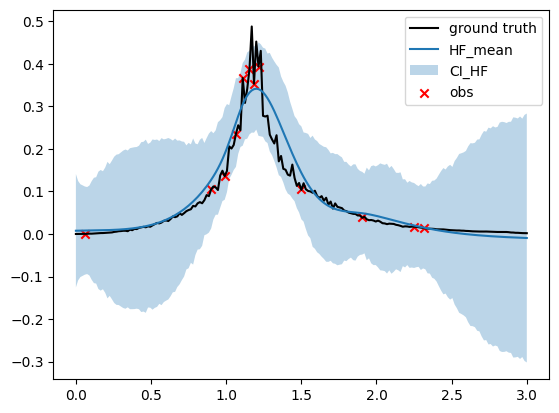

[60 66 71 74 77 81 79 82]


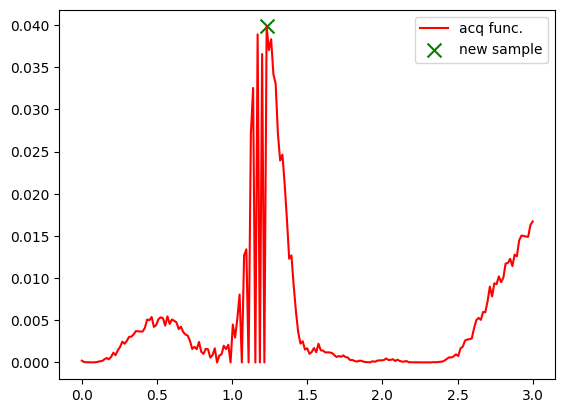

1.23 1.23
Evaluation 13 of 15

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 75.34it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 30.04it/s]


Completed. Saving
Time (s) to complete simulation 9: 23.29239797592163


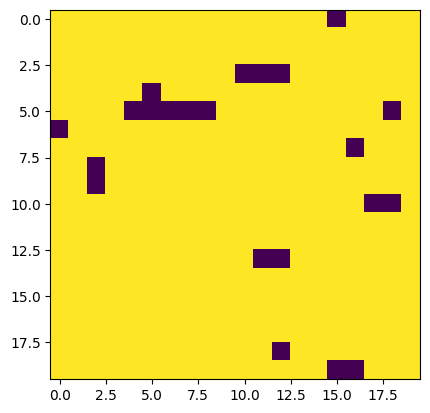

Step:9


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:09<00:00, 108.94it/s, 11 steps of size 2.84e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.16      0.13      0.12      0.04      0.28    155.47      1.00
   k_scale      0.15      0.18      0.07      0.01      0.42    187.32      1.01
     noise      0.00      0.01      0.00      0.00      0.01    127.83      1.01



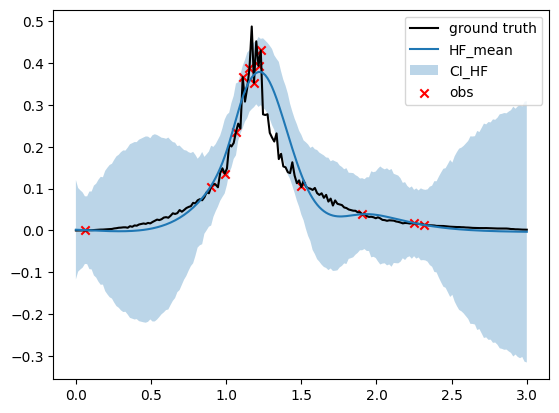

[60 66 71 74 77 81 79 82 84]


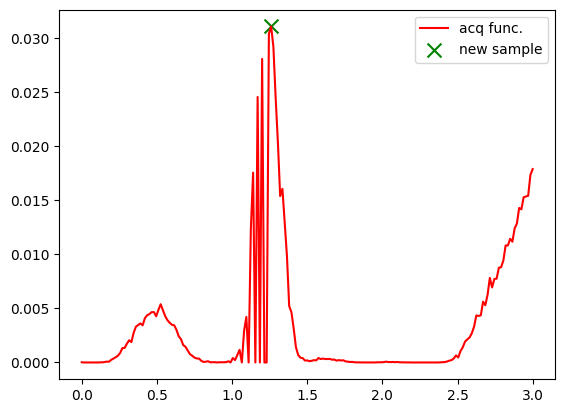

1.26 1.26
Evaluation 14 of 15

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 75.80it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 29.51it/s]


Completed. Saving
Time (s) to complete simulation 10: 23.54927086830139


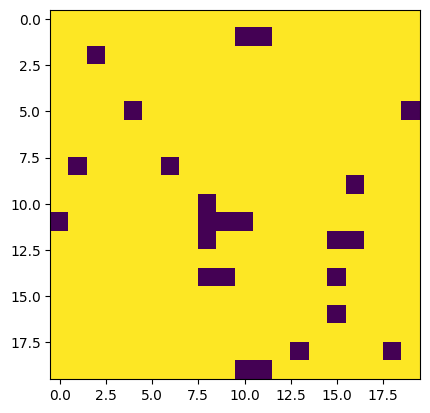

Step:10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:08<00:00, 120.32it/s, 15 steps of size 2.87e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.19      0.15      0.14      0.03      0.38    164.47      1.01
   k_scale      0.15      0.19      0.07      0.01      0.41    147.05      1.02
     noise      0.01      0.01      0.00      0.00      0.01    159.71      1.01



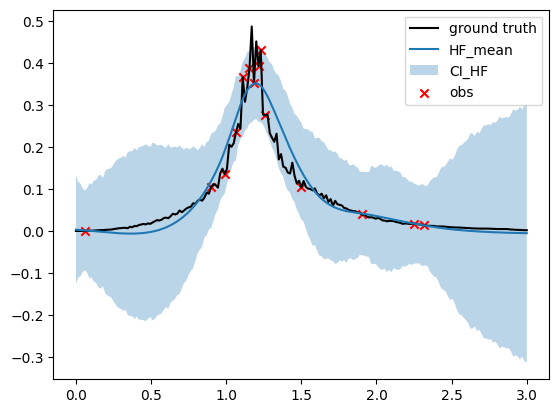

[60 66 71 74 77 81 79 82 84 78]


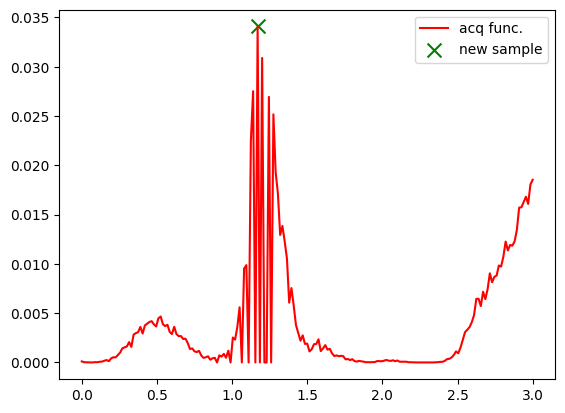

1.17 1.17
Evaluation 15 of 15

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 77.03it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 29.94it/s]


Completed. Saving
Time (s) to complete simulation 11: 23.197097301483154


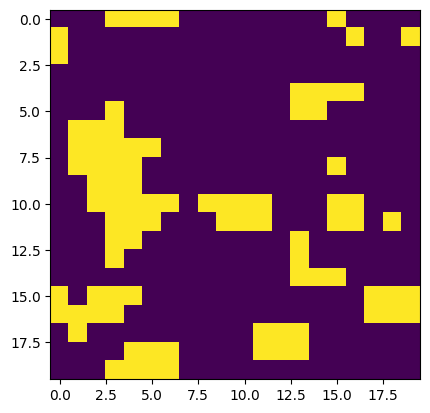

In [63]:
N = 10
X_test =xs
X_test_full = xs
X_test_norm = (X_test-bounds[0])/(bounds[1]-bounds[0])

# Get random number generator keys for training and prediction
np.random.seed(1)
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
for i in range(1, N+1):
    print("Step:"+str(i))


    # Initialize model
    gp_model = gpax.ExactGP(1, kernel='Matern', kernel_prior = kernel_prior,
                        noise_prior = lambda: numpyro.sample("noise", numpyro.distributions.HalfNormal(0.03)))
    # Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
    gp_model.fit(rng_key, train_x_full_norm, train_y, num_warmup=500, num_samples=500, num_chains=1)



    y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test_norm)
    plt.plot(xs, true_ys_sq, "k", label="ground truth")
    pred_lower = y_pred - y_sampled.std(axis=(0,1))
    pred_upper = y_pred + y_sampled.std(axis=(0,1))
    plt.plot(xs, y_pred, label="HF_mean")
    plt.fill_between(
        xs.flatten(),
        pred_lower,
        pred_upper,
        alpha=0.3,
        label="CI_HF",
    )
    plt.scatter(train_x_full, train_y, c="r", marker="x", label="obs")

    plt.legend(loc="best")
    plt.show()
    # Compute the EI acq function
    acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test_norm, maximize=True, noiseless=False)
    acq = np.array(acq)
    acq[idx] = 0
    next_point_val = acq.max()
    next_point_idx = acq.argmax()
    idx = np.hstack((idx, next_point_idx))

    if len(idx) == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)


    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        next_point_norm = X_test_norm[next_point_idx]
        train_x_full = np.vstack((train_x_full, next_point))
        train_x_full_norm = np.vstack((train_x_full_norm, next_point_norm))

        #Plot acquistion function
        plt.plot(xs, acq, "r", label="acq func.")
        plt.scatter(next_point, next_point_val, c="g", marker="x", label="new sample", s= 100)
        plt.legend(loc="best")
        plt.show()

        Jx=train_x_full[:,0]
        print(next_point, Jx[-1])
        J_mat = np.array([[0,0,0,0,0],
                  [0,0,Jx[-1],0,0],
                  [0,Jx[-1],0,Jx[-1],0],
                  [0,0,Jx[-1],0,0],
                  [0,0,0,0,0]])
        print("Evaluation " +str (n+i) +" of " +str(n+N))
        start_time = time.time()
        np.random.seed(0)
        sq_sim = IsingSim(N = 20, J_mat = J_mat, T = 2.7, save_trajectories=True, eqSteps = 500, mcSteps = 500)  # Intializing the object
        sq_sim.performIsingSim()   # Running the sim
        end_time = time.time()
        #time_eval[i]= end_time-start_time
        print("Time (s) to complete simulation " +str(i+1)+ ": " +str(end_time-start_time))
        resultsBO_dict[n+i] = {'sim': sq_sim.results,}
        new_y = resultsBO_dict[n+i]['sim']['SpecificHeat']
        plt.imshow(resultsBO_dict[n+i]['sim']['config'][-1])
        plt.show()
        train_y = np.vstack((train_y, new_y))





#Final GP prediction

/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:08<00:00, 123.24it/s, 11 steps of size 2.92e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.17      0.15      0.12      0.04      0.34    133.87      1.00
   k_scale      0.14      0.17      0.07      0.01      0.34    203.84      1.00
     noise      0.01      0.01      0.00      0.00      0.01    149.70      1.00



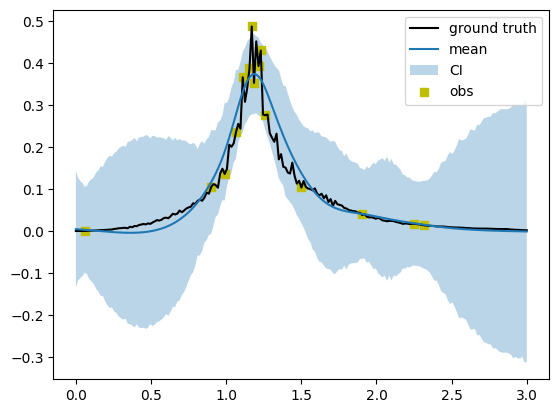

In [64]:
# Initialize model
gp_model = gpax.ExactGP(1, kernel='Matern', kernel_prior = kernel_prior,
                    noise_prior = lambda: numpyro.sample("noise", numpyro.distributions.HalfNormal(0.03)))
# Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
gp_model.fit(rng_key, train_x_full_norm, train_y, num_warmup=500, num_samples=500, num_chains=1)


y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test_norm)
plt.plot(xs, true_ys_sq, "k", label="ground truth")
pred_lower = y_pred - y_sampled.std(axis=(0,1))
pred_upper = y_pred + y_sampled.std(axis=(0,1))
plt.plot(xs, y_pred, label="mean")
plt.fill_between(
    xs.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="CI",
)
plt.scatter(train_x_full, train_y, c="y", marker="s", label="obs")

plt.legend(loc="best")
plt.show()

0.0006410663569667624


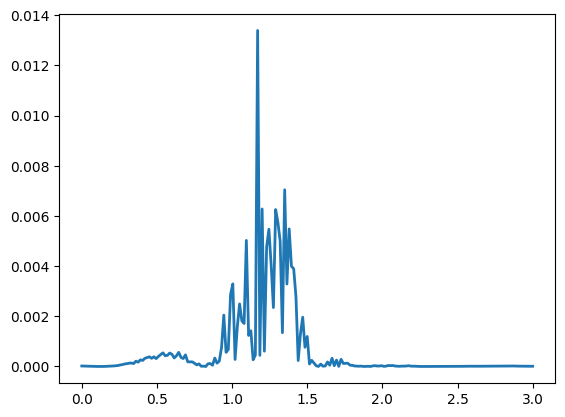

In [65]:
# Calculate MSE between HF ground truth and prediction values
error2_BO = (true_ys_sq-y_pred)**2
MSE_BO = np.mean(error2_BO)
print(MSE_BO)

plt.plot(xs, error2_BO, linewidth =2)


# End of tutorial of Standard Bayesian optimization

# BO with structured GP



- Start with same initial samples

In [66]:
train_x_full = train_x_full[0:n]
train_x_full_norm = train_x_full_norm[0:n]
train_y = train_y[0:n]
train_x_full, train_x_full_norm, train_y

(array([[2.31396193],
        [0.06225585],
        [1.9009447 ],
        [2.24641165],
        [1.49552104]]),
 array([[0.77132064],
        [0.02075195],
        [0.63364823],
        [0.74880388],
        [0.49850701]]),
 array([[0.01413402],
        [0.00039374],
        [0.03967774],
        [0.01734454],
        [0.10521883]]))

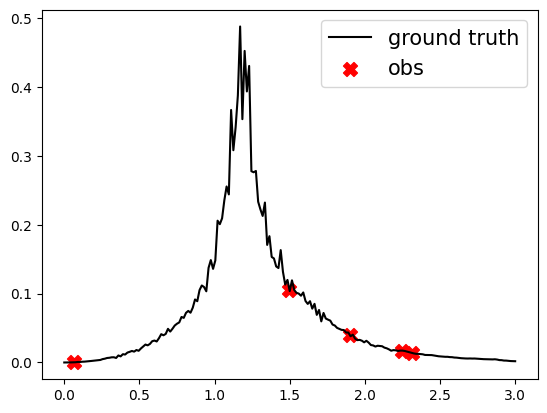

In [67]:
plt.plot(xs, true_ys_sq, "k", label="ground truth")

plt.scatter(train_x, train_y, c="r", marker="X", label="obs", s=100)

plt.legend(fontsize=15);

# GP mean function
- Prioir information functional form - Single peak function (eg. Gaussian)

In [68]:
@jit
def mean_func(x, params):

    x_data = x[:,0]
    #jax.debug.print("x_norm: {}", x_data)
    lb = 0
    ub = 3
    x_data = x_data*(ub-lb) + lb
    #jax.debug.print("x: {}", x_data)
    f = params["a"]*jnp.exp((-1/2)*(jnp.square(x_data-params["b"])/jnp.square(params["c"])))

    return  f


def mf_priors():
    a = numpyro.sample("a", numpyro.distributions.HalfNormal(0.5)) #Height of peak
    b = numpyro.sample("b", numpyro.distributions.HalfNormal(1.17)) #Position of peak
    c = numpyro.sample("c", numpyro.distributions.HalfNormal(2)) #Broadness of peak
    return {"a": a, "b": b, "c": c}

In [ ]:
#train_x_full = train_x_full[0:n]
#train_x_full_norm = train_x_full_norm[0:n]
#train_y = train_y[0:n]
#train_x_full, train_x_full_norm, train_y

# Run sBO

Step:1


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:12<00:00, 82.65it/s, 7 steps of size 3.03e-01. acc. prob=0.87] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.26      0.21      0.21      0.00      0.57    171.06      1.00
         b      0.88      0.66      0.72      0.00      1.80    267.04      1.00
         c      1.58      1.20      1.30      0.01      3.28    267.85      1.00
  k_length      0.65      0.24      0.66      0.32      1.00    274.57      1.01
   k_scale      0.21      0.24      0.11      0.01      0.60    327.20      1.00
     noise      0.01      0.01      0.00      0.00      0.02    433.45      1.00



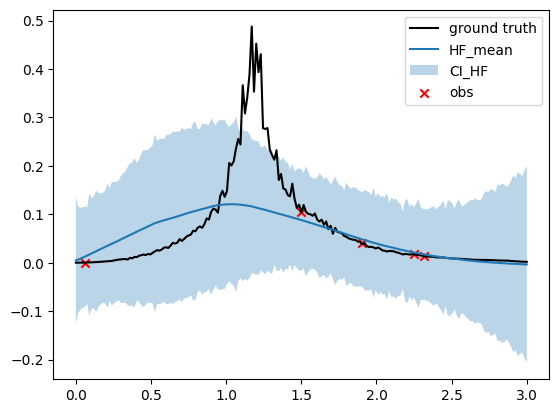

71


<ipython-input-69-d6e494dd04b3>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx = int(idx)


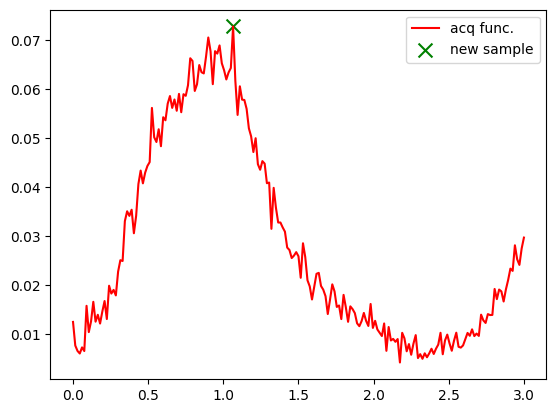

1.065 1.065
Evaluation 6 of 15

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 75.24it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 29.76it/s]


Completed. Saving
Time (s) to complete simulation 2: 23.45776343345642


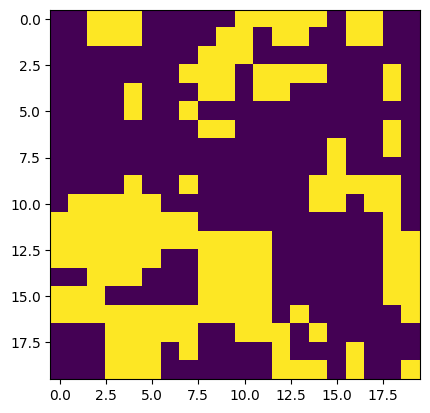

Step:2


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:13<00:00, 73.94it/s, 7 steps of size 2.92e-01. acc. prob=0.86]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.26      0.20      0.23      0.00      0.51    233.96      1.00
         b      0.87      0.63      0.73      0.00      1.73    182.74      1.01
         c      1.52      1.18      1.19      0.03      3.16    191.04      1.00
  k_length      0.62      0.25      0.65      0.28      0.99    327.92      1.00
   k_scale      0.26      0.27      0.15      0.01      0.68    219.76      1.00
     noise      0.01      0.01      0.00      0.00      0.02    445.78      1.00



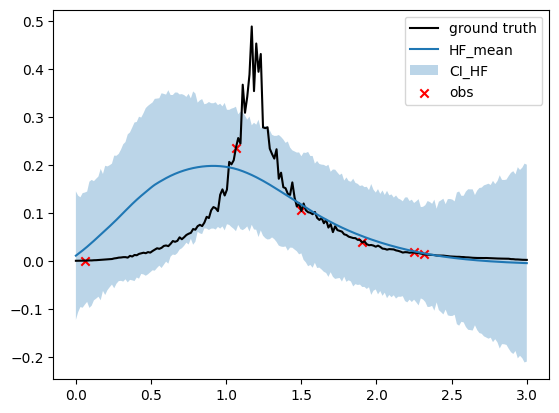

[71 52]


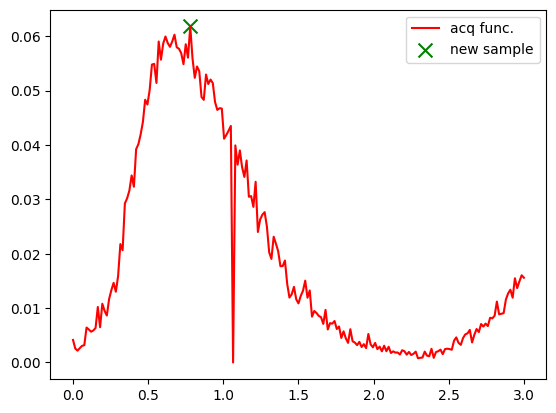

0.78 0.78
Evaluation 7 of 15

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 74.86it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 29.72it/s]


Completed. Saving
Time (s) to complete simulation 3: 23.508967638015747


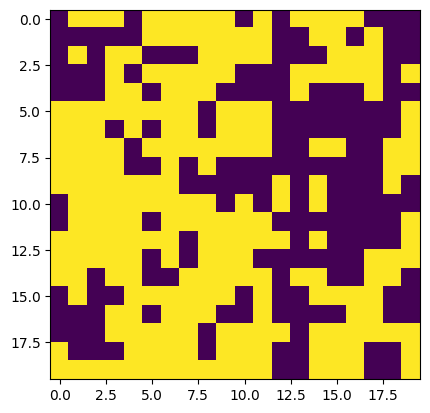

Step:3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:13<00:00, 74.97it/s, 7 steps of size 3.17e-01. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.25      0.19      0.21      0.00      0.52    294.01      1.00
         b      0.91      0.65      0.84      0.00      1.78    295.93      1.00
         c      1.75      1.10      1.53      0.19      3.28    373.00      1.00
  k_length      0.66      0.24      0.70      0.30      1.00    276.57      1.00
   k_scale      0.23      0.25      0.11      0.01      0.64    277.38      1.00
     noise      0.01      0.01      0.01      0.00      0.02    271.83      1.00



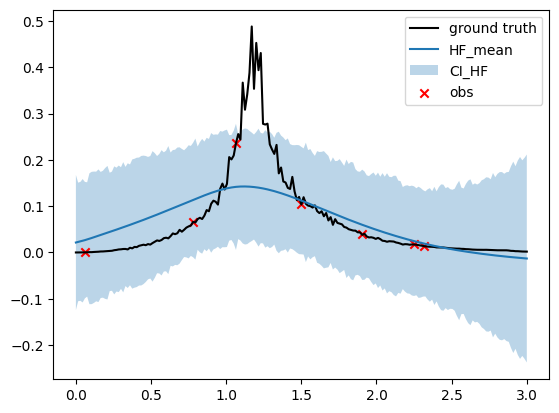

[71 52 81]


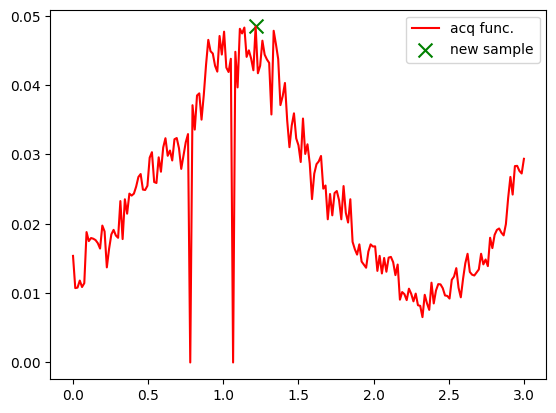

1.2149999999999999 1.2149999999999999
Evaluation 8 of 15

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 75.42it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 30.51it/s]


Completed. Saving
Time (s) to complete simulation 4: 23.027071237564087


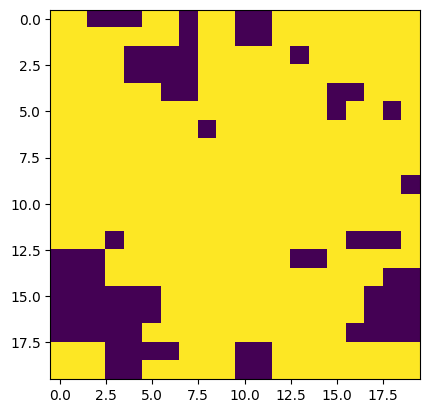

Step:4


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:14<00:00, 70.46it/s, 15 steps of size 3.34e-01. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.25      0.21      0.21      0.00      0.55    290.15      1.01
         b      0.96      0.71      0.84      0.00      1.88    317.59      1.01
         c      1.59      1.12      1.36      0.02      3.17    335.90      1.00
  k_length      0.58      0.28      0.61      0.13      0.96    294.06      1.00
   k_scale      0.26      0.27      0.13      0.01      0.68    282.24      1.01
     noise      0.02      0.01      0.02      0.00      0.04    411.94      1.00



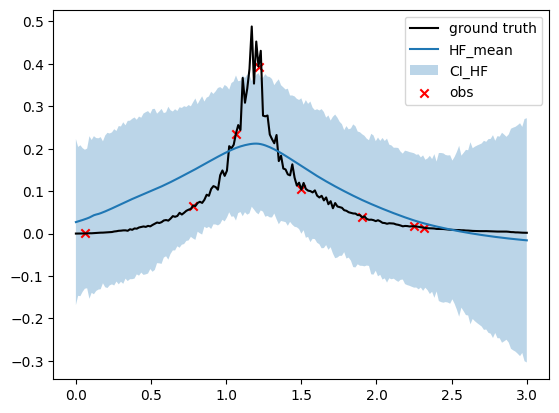

[71 52 81 77]


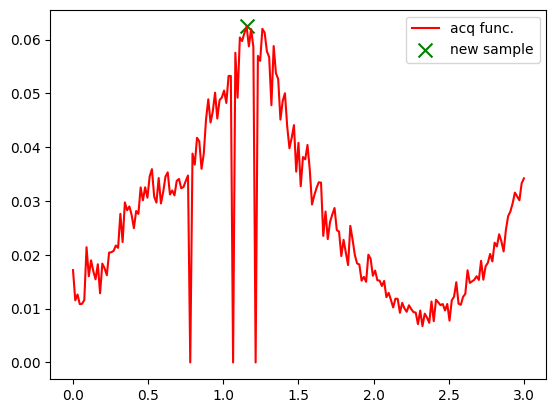

1.155 1.155
Evaluation 9 of 15

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 77.34it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 30.20it/s]


Completed. Saving
Time (s) to complete simulation 5: 23.029133558273315


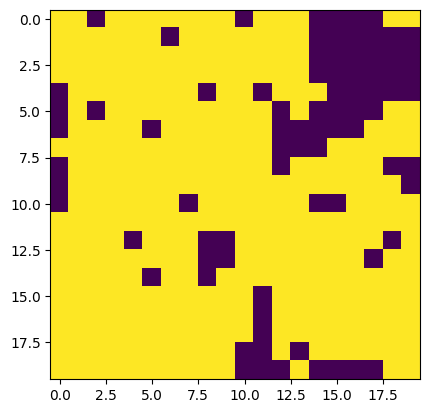

Step:5


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:24<00:00, 40.50it/s, 15 steps of size 2.43e-01. acc. prob=0.68]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.30      0.18      0.29      0.01      0.53    240.33      1.01
         b      0.99      0.54      1.07      0.00      1.59    169.62      1.02
         c      1.17      1.07      0.85      0.04      2.81     64.66      1.04
  k_length      0.54      0.28      0.60      0.05      0.91     81.67      1.03
   k_scale      0.29      0.27      0.17      0.01      0.71     39.60      1.01
     noise      0.01      0.01      0.01      0.00      0.03     96.20      1.01



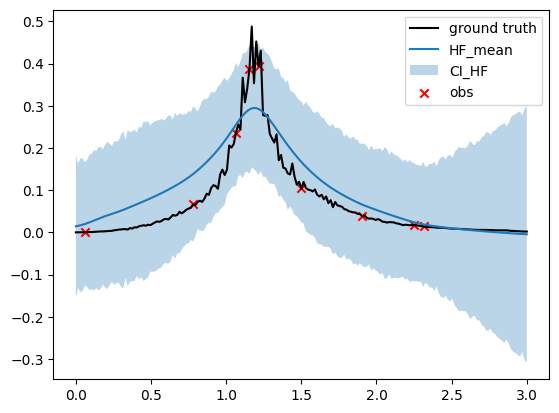

[71 52 81 77 79]


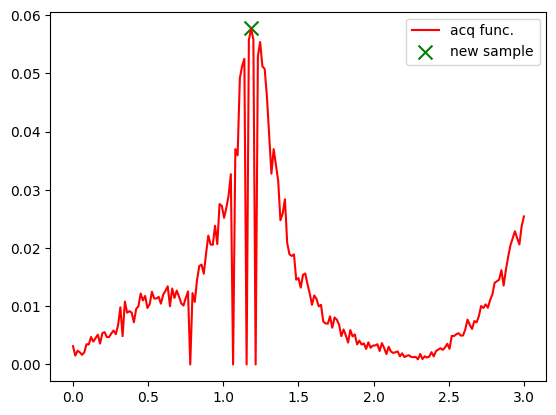

1.185 1.185
Evaluation 10 of 15

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 78.19it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 30.36it/s]


Completed. Saving
Time (s) to complete simulation 6: 22.878463745117188


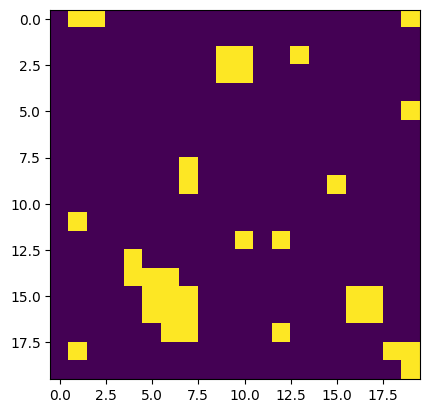

Step:6


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:29<00:00, 33.59it/s, 63 steps of size 8.24e-02. acc. prob=0.78]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.30      0.18      0.30      0.00      0.51    194.95      1.02
         b      1.02      0.48      1.14      0.00      1.42     65.99      1.01
         c      0.87      1.02      0.38      0.00      2.24     62.40      1.05
  k_length      0.52      0.31      0.52      0.05      0.94     50.36      1.06
   k_scale      0.20      0.22      0.10      0.01      0.55    111.16      1.00
     noise      0.01      0.01      0.01      0.00      0.03    145.19      1.02



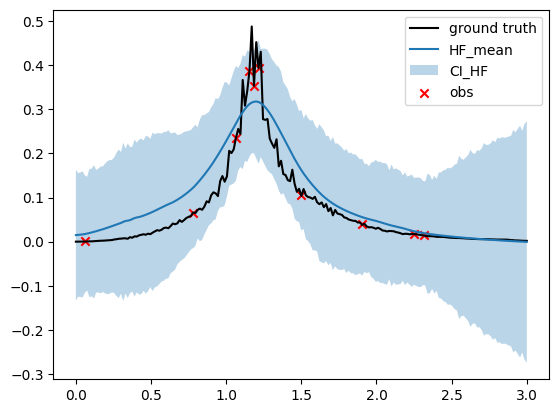

[71 52 81 77 79 84]


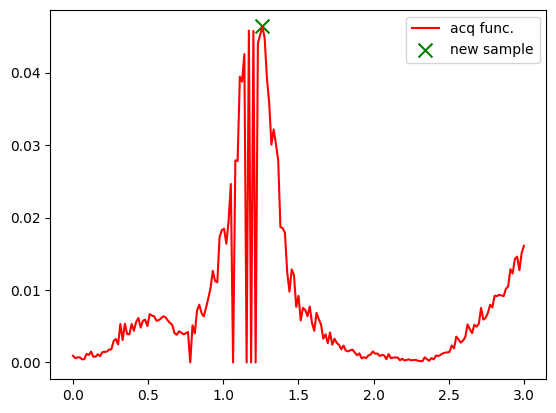

1.26 1.26
Evaluation 11 of 15

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 77.20it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 30.34it/s]


Completed. Saving
Time (s) to complete simulation 7: 22.967066287994385


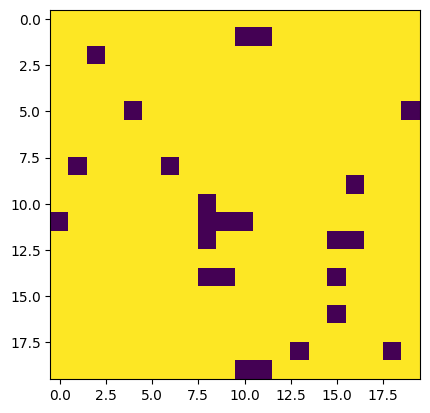

Step:7


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:17<00:00, 57.44it/s, 15 steps of size 1.91e-01. acc. prob=0.68]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.28      0.18      0.27      0.02      0.51    151.34      1.00
         b      0.99      0.59      1.09      0.01      1.52    118.63      1.00
         c      1.13      1.11      0.71      0.01      2.61     92.51      1.00
  k_length      0.45      0.27      0.42      0.03      0.86     97.30      1.00
   k_scale      0.20      0.24      0.09      0.01      0.60     78.62      1.01
     noise      0.01      0.01      0.01      0.00      0.02    152.29      1.01



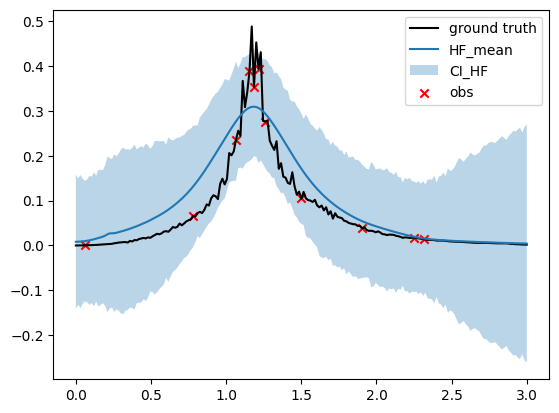

[71 52 81 77 79 84 78]


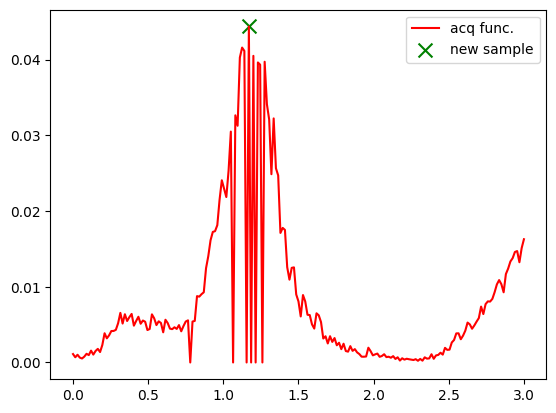

1.17 1.17
Evaluation 12 of 15

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 76.49it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 30.01it/s]


Completed. Saving
Time (s) to complete simulation 8: 23.207701206207275


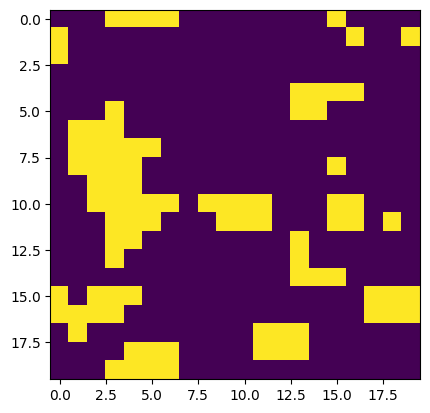

Step:8


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:40<00:00, 24.70it/s, 15 steps of size 1.18e-01. acc. prob=0.74]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.32      0.17      0.32      0.01      0.53    127.24      1.02
         b      1.01      0.53      1.13      0.00      1.51    137.15      1.01
         c      0.98      1.04      0.50      0.01      2.52    103.19      1.00
  k_length      0.48      0.29      0.46      0.04      0.93     79.48      1.06
   k_scale      0.20      0.22      0.10      0.01      0.55    130.23      1.00
     noise      0.01      0.01      0.01      0.00      0.03    142.43      1.01



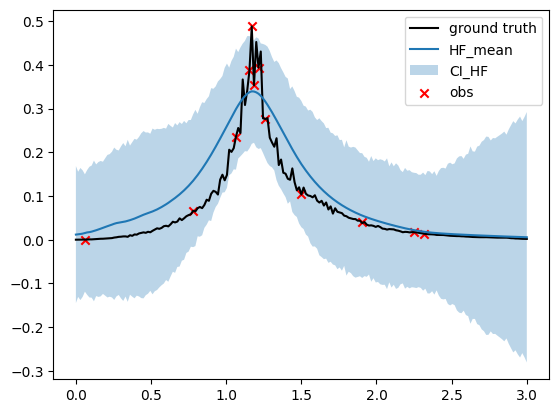

[71 52 81 77 79 84 78 76]


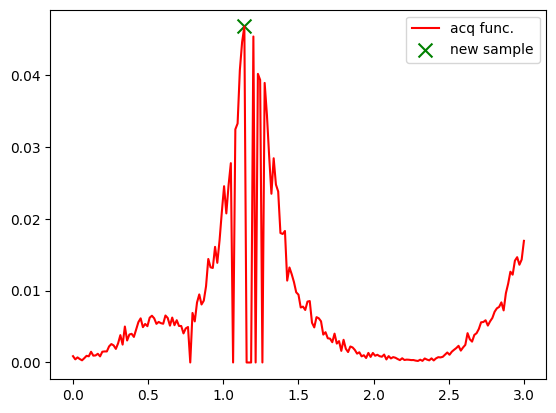

1.14 1.14
Evaluation 13 of 15

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 76.29it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 30.01it/s]


Completed. Saving
Time (s) to complete simulation 9: 23.22152590751648


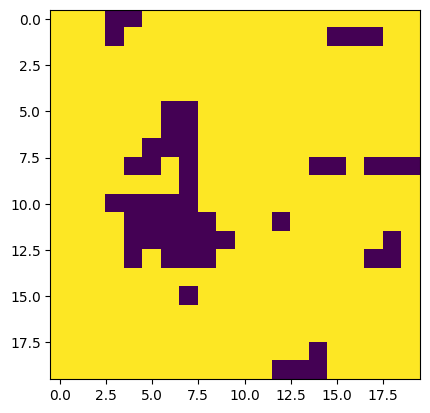

Step:9


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:25<00:00, 38.56it/s, 15 steps of size 1.44e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.33      0.12      0.33      0.13      0.56     66.98      1.01
         b      1.13      0.35      1.17      0.66      1.60     36.87      1.03
         c      0.43      0.68      0.18      0.05      1.24     37.20      1.02
  k_length      0.62      0.29      0.68      0.16      1.00     87.78      1.02
   k_scale      0.17      0.21      0.06      0.01      0.50    240.24      1.00
     noise      0.01      0.01      0.00      0.00      0.02    117.74      1.01



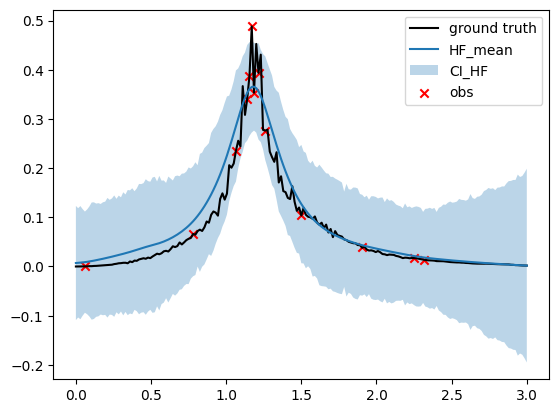

[71 52 81 77 79 84 78 76 80]


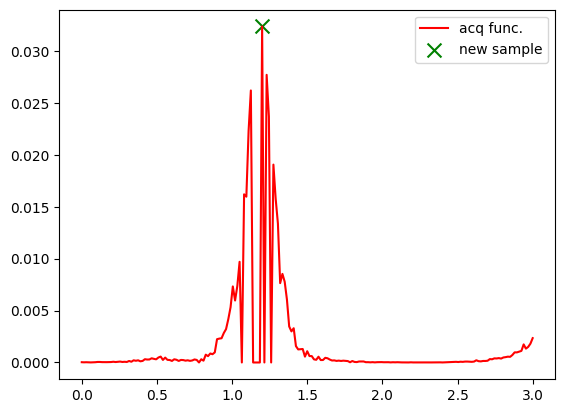

1.2 1.2
Evaluation 14 of 15

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 77.27it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 30.15it/s]


Completed. Saving
Time (s) to complete simulation 10: 23.064727067947388


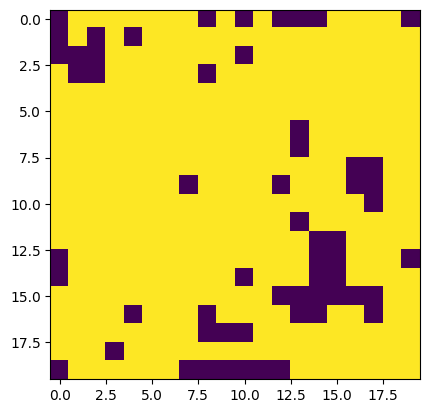

Step:10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:33<00:00, 30.06it/s, 31 steps of size 6.13e-02. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.31      0.12      0.33      0.09      0.46     74.33      1.01
         b      1.11      0.39      1.18      0.09      1.35     58.14      1.00
         c      0.48      0.81      0.15      0.01      1.40     54.18      1.03
  k_length      0.57      0.32      0.63      0.09      1.00     40.53      1.02
   k_scale      0.15      0.22      0.06      0.01      0.47    116.93      1.00
     noise      0.01      0.01      0.00      0.00      0.01    104.02      1.00



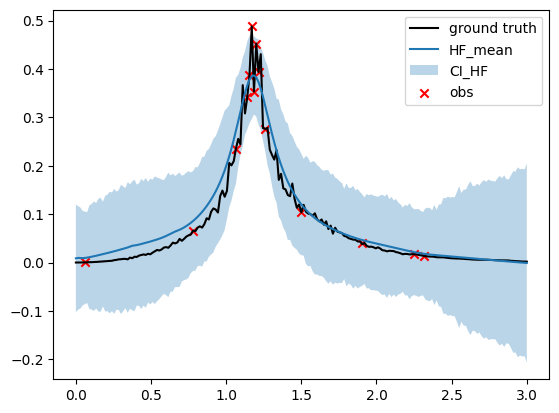

[71 52 81 77 79 84 78 76 80 82]


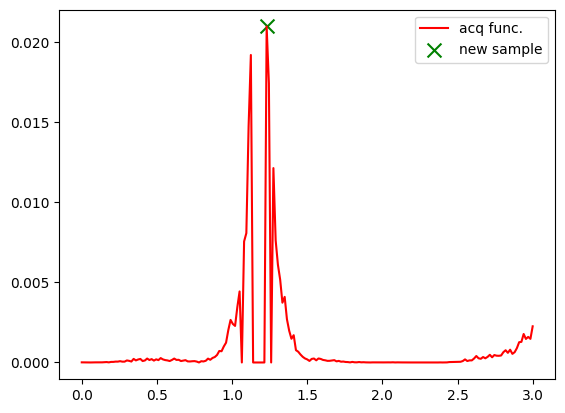

1.23 1.23
Evaluation 15 of 15

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 76.99it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 30.37it/s]


Completed. Saving
Time (s) to complete simulation 11: 22.968069076538086


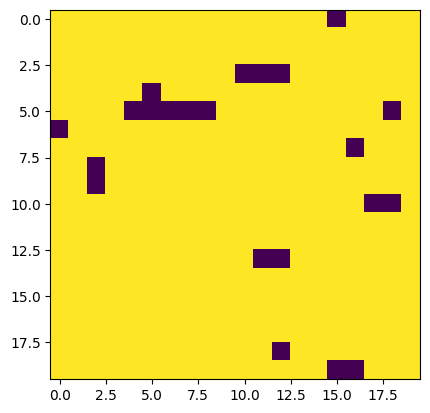

In [69]:
N = 10
X_test =xs
X_test_full = xs
X_test_norm = (X_test-bounds[0])/(bounds[1]-bounds[0])

# Get random number generator keys for training and prediction
np.random.seed(1)
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
for i in range(1, N+1):
    print("Step:"+str(i))


    # Initialize model
    gp_model = gpax.ExactGP(1, kernel='Matern', kernel_prior = kernel_prior, mean_fn= mean_func, mean_fn_prior=mf_priors,
                        noise_prior = lambda: numpyro.sample("noise", numpyro.distributions.HalfNormal(0.03)))
    # Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
    gp_model.fit(rng_key, train_x_full_norm, train_y, num_warmup=500, num_samples=500, num_chains=1)



    y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test_norm)
    plt.plot(xs, true_ys_sq, "k", label="ground truth")
    pred_lower = y_pred - y_sampled.std(axis=(0,1))
    pred_upper = y_pred + y_sampled.std(axis=(0,1))
    plt.plot(xs, y_pred, label="HF_mean")
    plt.fill_between(
        xs.flatten(),
        pred_lower,
        pred_upper,
        alpha=0.3,
        label="CI_HF",
    )
    plt.scatter(train_x_full, train_y, c="r", marker="x", label="obs")

    plt.legend(loc="best")
    plt.show()
    # Compute the EI acq function
    acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test_norm, maximize=True, noiseless=False)
    acq = np.array(acq)
    acq[idx] = 0
    next_point_val = acq.max()
    next_point_idx = acq.argmax()
    idx = np.hstack((idx, next_point_idx))

    if len(idx) == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)


    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        next_point_norm = X_test_norm[next_point_idx]
        train_x_full = np.vstack((train_x_full, next_point))
        train_x_full_norm = np.vstack((train_x_full_norm, next_point_norm))

        #Plot acquistion function
        plt.plot(xs, acq, "r", label="acq func.")
        plt.scatter(next_point, next_point_val, c="g", marker="x", label="new sample", s= 100)
        plt.legend(loc="best")
        plt.show()

        Jx=train_x_full[:,0]
        print(next_point, Jx[-1])
        J_mat = np.array([[0,0,0,0,0],
                  [0,0,Jx[-1],0,0],
                  [0,Jx[-1],0,Jx[-1],0],
                  [0,0,Jx[-1],0,0],
                  [0,0,0,0,0]])
        print("Evaluation " +str (n+i) +" of " +str(n+N))
        start_time = time.time()
        np.random.seed(0)
        sq_sim = IsingSim(N = 20, J_mat = J_mat, T = 2.7, save_trajectories=True, eqSteps = 500, mcSteps = 500)  # Intializing the object
        sq_sim.performIsingSim()   # Running the sim
        end_time = time.time()
        #time_eval[i]= end_time-start_time
        print("Time (s) to complete simulation " +str(i+1)+ ": " +str(end_time-start_time))
        resultsBO_dict[n+i] = {'sim': sq_sim.results,}
        new_y = resultsBO_dict[n+i]['sim']['SpecificHeat']
        plt.imshow(resultsBO_dict[n+i]['sim']['config'][-1])
        plt.show()
        train_y = np.vstack((train_y, new_y))



# Final GP prediction

/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:32<00:00, 30.88it/s, 7 steps of size 8.63e-02. acc. prob=0.43] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.35      0.13      0.37      0.08      0.50     45.23      1.01
         b      1.14      0.35      1.19      0.38      1.40    149.85      1.00
         c      0.47      0.82      0.17      0.00      1.36     42.05      1.04
  k_length      0.65      0.32      0.82      0.14      0.98     15.97      1.04
   k_scale      0.11      0.16      0.06      0.01      0.29     77.52      1.01
     noise      0.01      0.00      0.01      0.00      0.01     63.27      1.01



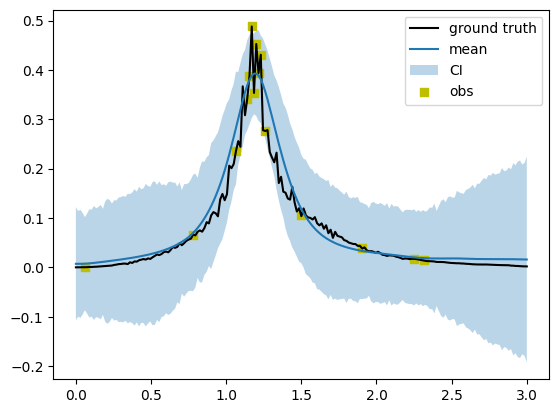

In [70]:
# Initialize model
gp_model = gpax.ExactGP(1, kernel='Matern', kernel_prior = kernel_prior, mean_fn= mean_func, mean_fn_prior=mf_priors,
                    noise_prior = lambda: numpyro.sample("noise", numpyro.distributions.HalfNormal(0.03)))
# Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
gp_model.fit(rng_key, train_x_full_norm, train_y, num_warmup=500, num_samples=500, num_chains=1)


y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test_norm)
plt.plot(xs, true_ys_sq, "k", label="ground truth")
pred_lower = y_pred - y_sampled.std(axis=(0,1))
pred_upper = y_pred + y_sampled.std(axis=(0,1))
plt.plot(xs, y_pred, label="mean")
plt.fill_between(
    xs.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="CI",
)
plt.scatter(train_x_full, train_y, c="y", marker="s", label="obs")

plt.legend(loc="best")
plt.show()

0.0006410663569667624 0.0006376493867098965


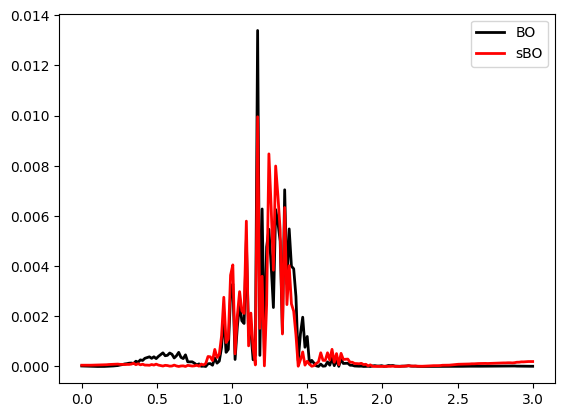

In [71]:
# Calculate MSE between HF ground truth and prediction values
error2_sBO = (true_ys_sq-y_pred)**2
MSE_sBO = np.mean(error2_sBO)
print(MSE_BO, MSE_sBO)

plt.plot(xs, error2_BO, c="k", linewidth =2, label="BO")
plt.plot(xs, error2_sBO, c="r", linewidth =2, label="sBO")
plt.legend(loc="best")
plt.show()

sBO provides better convergence than BO with same computational cost, thus accelerate learning with physics knowledge injection